In [412]:
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import scipy
import logging
   
PATH_TO_DATA = r'/Users/nadiiapoliakovska/Documents/Air_Pollution (Justin)'
PM25_pattern = r'Cal_PM2.5*.csv'
CO_pattern = r'Cal_CO*.csv'
EPA_O_3_pattern = r'EPA_O_3.csv'
    
class State:

    def __init__(self, path_to_folder, pattern):
        self.path_to_folder = path_to_folder
        self.pattern = pattern
    
    def create_df(self): 
        '''path_to_folder can be assigned to PATH_TO_DATA
        pattern for California is
        r'Cal_PM2.5*.csv' or
        r'Cal_CO*.csv' or
        r'EPA_O_3.csv' '''
        files = glob.glob(os.path.join(self.path_to_folder, self.pattern))
        if len(files) > 1:
            df_list = []
            for i in files:
                df = pd.read_csv(i)
                df_list.append(df)
            big_df = pd.concat(df_list, ignore_index = True)
        elif len(files) == 1:
            big_df = pd.read_csv(files[0])
        else:
            big_df = "No files in the folder with this pattern"
        return big_df 
    
    def county_names(self, path_to_folder, pattern):
        df = State(path_to_folder, pattern).create_df()
        return df['COUNTY'].unique()

In [409]:
class County(State):
    def __init__(self, path_to_folder, pattern, county): #county shoud be string
        super().__init__(path_to_folder, pattern)
        self.county = county
        
    def sub_df(self): 
        logging.basicConfig(level=logging.ERROR)
        df = super().create_df()
        if self.county in df['COUNTY'].unique():
            county_df = df.loc[df['COUNTY'] == self.county]
            county_df.loc[:,'Date'] = county_df.loc[:, 'Date'].apply(pd.to_datetime)
            county_df = county_df.sort_values(by=['Date'])
            ind = np.arange(0, len(county_df))
            county_df.set_index(ind, inplace = True)
        else: 
            print("No such county in this dataframe")
        return county_df
    
    def diff_values(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.sub_df()
        l =[]
        for i in df.columns:
            if len(df[i].unique())!=1 :
                l.append(i)
        return l
    
    def sub_df_unique(self):
        df = self.sub_df()
        df_unique = df[['Date', 'Daily Mean PM2.5 Concentration', 'Site Name', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
        df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        df_unique = df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        df_unique['Month'] = pd.DatetimeIndex(df_unique['Date']).month
        df_unique['Year_Month'] = pd.DatetimeIndex(df_unique['Date']).to_period('M')
        df_unique['Year'] = pd.DatetimeIndex(df_unique['Date']).year
        return df_unique
    
    def preprocessed(self):
        logging.basicConfig(level=logging.ERROR)
        county_df_unique = self.sub_df()
           
        #county_df_unique = county_df[self.diff_values()]    
            
        if (county_df_unique['UNITS'].unique() != 'ug/m3 LC').any() or (len(county_df_unique['UNITS'].unique())==2):
            county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'] = 1000*county_df_unique.loc[county_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration']
            county_df_unique['UNITS'] = county_df_unique['UNITS'].replace('ppm', 'ug/m3 LC')
        county_df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)
        
        if county_df_unique['Site Name'].isna().unique().all():
            county_df_unique == county_df_unique
        elif "Site Name" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
        elif "COUNTY" in county_df_unique.columns:
            county_df_unique = county_df_unique.groupby(by= ["Date", "COUNTY"], as_index = False).mean()
        else:
            print('No COUNTY or Site Name in columns name of the ' + self.county + ' dataframe')
            for j in ["Site Name", "County"]:
                if j in county_df.columns:
                    county_df_unique = county_df_unique.join(county_df[j])
                    print("Joined " + j + " to " + self.county + '  unique dataframe')
                    county_df_unique = county_df_unique.groupby(by= ["Date", j], as_index = False).mean()
                else:
                    print("No " + j +" in "+ self.county + ' dataframe')
        
        county_df_unique['Month'] = pd.DatetimeIndex(county_df_unique['Date']).month
        county_df_unique['Year_Month'] = pd.DatetimeIndex(county_df_unique['Date']).to_period('M')
        county_df_unique['Year'] = pd.DatetimeIndex(county_df_unique['Date']).year

        return county_df_unique
    
    def county_plot_Daily_PM25(self):
        logging.basicConfig(level=logging.ERROR)
        df = self.preprocessed()
        %matplotlib inline
        plt.figure(figsize = (16, 10))
        x = df['Date']
        y = df['Daily Mean PM2.5 Concentration, ug/m3 LC']
        
            
        plt.stem(x, y, markerfmt=' ', basefmt=' ')  # No baseline for stems         
        # Beautify the x-axis by formatting dates
        #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.YearLocator())         
        plt.xlabel('Date', fontsize=20)
        plt.ylabel('Daily Mean PM2.5 Concentration, ug/m³ LC', fontsize=20)
        plt.title("Daily PM2.5 concentration changes with years for " + self.county + " county", fontsize=20)
        plt.grid()
        # Increase the font size of x and y ticks
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        #California = super().create_df()
        #plt.xlim(pd.to_datetime(California["Date"].min(), format = '%m/%d/%Y'),
        #     pd.to_datetime(California["Date"].max(), format = '%m/%d/%Y'))
        #plt.ylim(California["Daily Mean PM2.5 Concentration"].min(), California["Daily Mean PM2.5 Concentration"].max())
        plt.savefig("Air_Pollution_plots/Daily PM2.5 concentration changes with years/Daily PM2.5 concentration changes with years for " + self.county + " county.pdf", format="pdf", bbox_inches="tight")
        # Show the plot
        plt.tight_layout()
        plt.show()

In [368]:
"""# Define a list of county names
county_names = CA.county_names(PATH_TO_DATA, PM25_pattern)

# Create an empty dictionary to store dataframes
county_dataframes = {}
county_dataframes_unique = {}

# Iterate through each county and create dataframes
for county_name in county_names:
    county = County(PATH_TO_DATA, PM25_pattern, county_name)
    county_df = county.sub_df()
    
    # Store the dataframe in the dictionary with the county name as the key
    county_dataframes[county_name] = county_df
    
    #Create dataframe with mean Daily Mean PM2.5 Concentration values for each day  
    county_df_unique = county_df[['Date', 'Daily Mean PM2.5 Concentration', 'Site Name', 'SITE_LATITUDE', 'SITE_LONGITUDE']]
    county_df_unique = county_df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
    county_dataframes_unique[county_name] = county_df_unique"""

In [413]:
CA = State(PATH_TO_DATA, PM25_pattern)
CA.county_names(PATH_TO_DATA, PM25_pattern)

array(['Alameda', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa',
       'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt',
       'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Los Angeles',
       'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Mono',
       'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas',
       'Riverside', 'Sacramento', 'San Benito', 'San Bernardino',
       'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo',
       'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz',
       'Shasta', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter',
       'Tehama', 'Trinity', 'Tulare', 'Ventura', 'Yolo', 'Alpine',
       'Allen', 'Bartholomew', 'Clark', 'Delaware', 'Dubois', 'Elkhart',
       'Floyd', 'Greene', 'Hamilton', 'Henry', 'Howard', 'LaPorte',
       'Madison', 'Marion', 'Monroe', 'Porter', 'St. Joseph', 'Spencer',
       'Sullivan', 'Tippecanoe', 'Vanderburgh', 'Vigo', 'Whitley'],
      dtype=object)

In [414]:
Alameda = County(PATH_TO_DATA, PM25_pattern,'Alameda')
Alameda_df = Alameda.sub_df()
Alameda_df.head()

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Date Source   Site ID  POC  Daily Mean PM2.5 Concentration     UNITS  \
0 2010-01-01    AQS  60010009    3                            12.2  ug/m3 LC   
1 2010-01-01    AQS  60012004    1                            11.8  ug/m3 LC   
2 2010-01-01    AQS  60010011    1                            14.7  ug/m3 LC   
3 2010-01-01    AQS  60010007    1                            18.5  ug/m3 LC   
4 2010-01-01    AQS  60011001    3                            14.5  ug/m3 LC   

   DAILY_AQI_VALUE             Site Name  DAILY_OBS_COUNT  PERCENT_COMPLETE  \
0               51               Oakland                1               100   
1               49              Berkeley                1               100   
2               56          Oakland West                1               100   
3               64             Livermore                1               100   
4               56  Fremont - Chapel Way                1               100   

   ...                      AQS_PARAMETER_DESC CBSA_CODE  \
0  ...                PM2.5 - Local Conditions   41860.0   
1  ...  Acceptable PM2.5 AQI & Speciation Mass   41860.0   
2  ...  Acceptable PM2.5 AQI & Speciation Mass   41860.0   
3  ...  Acceptable PM2.5 AQI & Speciation Mass   41860.0   
4  ...                PM2.5 - Local Conditions   41860.0   

                           CBSA_NAME STATE_CODE       STATE COUNTY_CODE  \
0  San Francisco-Oakland-Hayward, CA          6  California           1   
1  San Francisco-Oakland-Hayward, CA          6  California           1   
2  San Francisco-Oakland-Hayward, CA          6  California           1   
3  San Francisco-Oakland-Hayward, CA          6  California           1   
4  San Francisco-Oakland-Hayward, CA          6  California           1   

    COUNTY SITE_LATITUDE  SITE_LONGITUDE  Daily Max 8-hour CO Concentration  
0  Alameda     37.743065     -122.169935                                NaN  
1  Alameda     37.877794     -122.301290                                NaN  
2  Alameda     37.814781     -122.282347                                NaN  
3  Alameda     37.687526     -121.784217                                NaN  
4  Alameda     37.535833     -121.961823                                NaN  

[5 rows x 21 columns]

In [378]:
Alameda_df['Site Name'].unique()

array(['Oakland', 'Berkeley', 'Oakland West', 'Livermore',
       'Fremont - Chapel Way', 'Laney College', 'Berkeley- Aquatic Park',
       'Pleasanton - Owens Ct'], dtype=object)

In [5]:
Alameda_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17640 entries, 0 to 17639
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Date                               17640 non-null  datetime64[ns]
 1   Source                             17640 non-null  object        
 2   Site ID                            17640 non-null  int64         
 3   POC                                17640 non-null  int64         
 4   Daily Mean PM2.5 Concentration     16911 non-null  float64       
 5   UNITS                              17640 non-null  object        
 6   DAILY_AQI_VALUE                    17640 non-null  int64         
 7   Site Name                          17640 non-null  object        
 8   DAILY_OBS_COUNT                    17640 non-null  int64         
 9   PERCENT_COMPLETE                   17640 non-null  int64         
 10  AQS_PARAMETER_CODE                

In [147]:
Alameda.diff_values()

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


['Date',
 'Site ID',
 'POC',
 'Daily Mean PM2.5 Concentration',
 'UNITS',
 'DAILY_AQI_VALUE',
 'Site Name',
 'DAILY_OBS_COUNT',
 'PERCENT_COMPLETE',
 'AQS_PARAMETER_CODE',
 'AQS_PARAMETER_DESC',
 'SITE_LATITUDE',
 'SITE_LONGITUDE',
 'Daily Max 8-hour CO Concentration']

In [234]:
Alameda_df_unique = Alameda_df[Alameda.diff_values()]
Alameda_df_unique

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Date   Site ID  POC  Daily Mean PM2.5 Concentration     UNITS  \
0     2010-01-01  60010009    3                            12.2  ug/m3 LC   
1     2010-01-01  60012004    1                            11.8  ug/m3 LC   
2     2010-01-01  60010011    1                            14.7  ug/m3 LC   
3     2010-01-01  60010007    1                            18.5  ug/m3 LC   
4     2010-01-01  60011001    3                            14.5  ug/m3 LC   
...          ...       ...  ...                             ...       ...   
17635 2021-12-31  60010011    3                             4.7  ug/m3 LC   
17636 2021-12-31  60010007    3                            12.5  ug/m3 LC   
17637 2021-12-31  60010012    3                             3.0  ug/m3 LC   
17638 2021-12-31  60010009    3                             8.3  ug/m3 LC   
17639 2021-12-31  60010015    3                             5.2  ug/m3 LC   

       DAILY_AQI_VALUE              Site Name  DAILY_OBS_COUNT  \
0                   51                Oakland                1   
1                   49               Berkeley                1   
2                   56           Oakland West                1   
3                   64              Livermore                1   
4                   56   Fremont - Chapel Way                1   
...                ...                    ...              ...   
17635               20           Oakland West                1   
17636               52              Livermore                1   
17637               13          Laney College                1   
17638               35                Oakland                1   
17639               22  Pleasanton - Owens Ct                1   

       PERCENT_COMPLETE  AQS_PARAMETER_CODE  \
0                   100               88101   
1                   100               88502   
2                   100               88502   
3                   100               88502   
4                   100               88101   
...                 ...                 ...   
17635               100               88101   
17636               100               88101   
17637               100               88101   
17638               100               88101   
17639               100               88101   

                           AQS_PARAMETER_DESC  SITE_LATITUDE  SITE_LONGITUDE  \
0                    PM2.5 - Local Conditions      37.743065     -122.169935   
1      Acceptable PM2.5 AQI & Speciation Mass      37.877794     -122.301290   
2      Acceptable PM2.5 AQI & Speciation Mass      37.814781     -122.282347   
3      Acceptable PM2.5 AQI & Speciation Mass      37.687526     -121.784217   
4                    PM2.5 - Local Conditions      37.535833     -121.961823   
...                                       ...            ...             ...   
17635                PM2.5 - Local Conditions      37.814781     -122.282347   
17636                PM2.5 - Local Conditions      37.687526     -121.784217   
17637                PM2.5 - Local Conditions      37.793624     -122.263376   
17638                PM2.5 - Local Conditions      37.743065     -122.169935   
17639                PM2.5 - Local Conditions      37.701222     -121.903019   

       Daily Max 8-hour CO Concentration  
0                                    NaN  
1                                    NaN  
2                                    NaN  
3                                    NaN  
4                                    NaN  
...                                  ...  
17635                                NaN  
17636                                NaN  
17637                                NaN  
17638                                NaN  
17639                                NaN  

[17640 rows x 14 columns]

In [8]:
Alameda_df_unique['AQS_PARAMETER_DESC'].value_counts()

PM2.5 - Local Conditions                  14840
Acceptable PM2.5 AQI & Speciation Mass     2071
Carbon monoxide                             729
Name: AQS_PARAMETER_DESC, dtype: int64

In [9]:
Alameda_df_unique['UNITS'].unique()

array(['ug/m3 LC', 'ppm'], dtype=object)

In [235]:
Alameda_df_unique.loc[Alameda_df_unique['UNITS'] == 'ppm']['Daily Mean PM2.5 Concentration'].isna().all()

True

In [236]:
Alameda_df_unique.rename(columns={"Daily Mean PM2.5 Concentration": "Daily Mean PM2.5 Concentration, ug/m3 LC"},
                 inplace = True)

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [12]:
Alameda_df_unique['DAILY_OBS_COUNT'].unique()

array([ 1, 18, 24, 23, 21, 22, 16, 14, 17,  5,  8, 20, 12, 11,  9, 15, 13,
       10, 19])

In [13]:
Alameda_df_unique['PERCENT_COMPLETE'].unique()

array([100,  75,  96,  88,  92,  67,  58,  71,  21,  33,  83,  50,  46,
        38,  63,  54,  42,  79])

In [237]:
sum(Alameda_df_unique['Daily Max 8-hour CO Concentration'].isna())

16911

In [238]:
Alameda_df_unique.drop(columns=['Site ID', 'UNITS', 'DAILY_OBS_COUNT', 'AQS_PARAMETER_CODE'], inplace = True)

/Users/nadiiapoliakovska/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [239]:
sum(Alameda_df_unique.duplicated())

0

In [17]:
Alameda_df_unique

Date  POC  Daily Mean PM2.5 Concentration, ug/m3 LC  \
0     2010-01-01    3                                      12.2   
1     2010-01-01    1                                      11.8   
2     2010-01-01    1                                      14.7   
3     2010-01-01    1                                      18.5   
4     2010-01-01    3                                      14.5   
...          ...  ...                                       ...   
17635 2021-12-31    3                                       4.7   
17636 2021-12-31    3                                      12.5   
17637 2021-12-31    3                                       3.0   
17638 2021-12-31    3                                       8.3   
17639 2021-12-31    3                                       5.2   

       DAILY_AQI_VALUE              Site Name  PERCENT_COMPLETE  \
0                   51                Oakland               100   
1                   49               Berkeley               100   
2                   56           Oakland West               100   
3                   64              Livermore               100   
4                   56   Fremont - Chapel Way               100   
...                ...                    ...               ...   
17635               20           Oakland West               100   
17636               52              Livermore               100   
17637               13          Laney College               100   
17638               35                Oakland               100   
17639               22  Pleasanton - Owens Ct               100   

                           AQS_PARAMETER_DESC  SITE_LATITUDE  SITE_LONGITUDE  \
0                    PM2.5 - Local Conditions      37.743065     -122.169935   
1      Acceptable PM2.5 AQI & Speciation Mass      37.877794     -122.301290   
2      Acceptable PM2.5 AQI & Speciation Mass      37.814781     -122.282347   
3      Acceptable PM2.5 AQI & Speciation Mass      37.687526     -121.784217   
4                    PM2.5 - Local Conditions      37.535833     -121.961823   
...                                       ...            ...             ...   
17635                PM2.5 - Local Conditions      37.814781     -122.282347   
17636                PM2.5 - Local Conditions      37.687526     -121.784217   
17637                PM2.5 - Local Conditions      37.793624     -122.263376   
17638                PM2.5 - Local Conditions      37.743065     -122.169935   
17639                PM2.5 - Local Conditions      37.701222     -121.903019   

       Daily Max 8-hour CO Concentration  
0                                    NaN  
1                                    NaN  
2                                    NaN  
3                                    NaN  
4                                    NaN  
...                                  ...  
17635                                NaN  
17636                                NaN  
17637                                NaN  
17638                                NaN  
17639                                NaN  

[17640 rows x 10 columns]

In [18]:
Alameda_df_unique[Alameda_df_unique["Site Name"] == 'Livermore']

Date  POC  Daily Mean PM2.5 Concentration, ug/m3 LC  \
3     2010-01-01    1                                      18.5   
7     2010-01-02    5                                       8.4   
10    2010-01-02    1                                      10.7   
16    2010-01-03    1                                       9.7   
18    2010-01-04    1                                      30.5   
...          ...  ...                                       ...   
17616 2021-12-27    3                                       3.7   
17621 2021-12-28    3                                       4.7   
17628 2021-12-29    3                                       3.4   
17632 2021-12-30    3                                       4.6   
17636 2021-12-31    3                                      12.5   

       DAILY_AQI_VALUE  Site Name  PERCENT_COMPLETE  \
3                   64  Livermore               100   
7                   35  Livermore               100   
10                  45  Livermore               100   
16                  40  Livermore               100   
18                  90  Livermore               100   
...                ...        ...               ...   
17616               15  Livermore               100   
17621               20  Livermore               100   
17628               14  Livermore               100   
17632               19  Livermore               100   
17636               52  Livermore               100   

                           AQS_PARAMETER_DESC  SITE_LATITUDE  SITE_LONGITUDE  \
3      Acceptable PM2.5 AQI & Speciation Mass      37.687526     -121.784217   
7      Acceptable PM2.5 AQI & Speciation Mass      37.687526     -121.784217   
10                   PM2.5 - Local Conditions      37.687526     -121.784217   
16     Acceptable PM2.5 AQI & Speciation Mass      37.687526     -121.784217   
18                   PM2.5 - Local Conditions      37.687526     -121.784217   
...                                       ...            ...             ...   
17616                PM2.5 - Local Conditions      37.687526     -121.784217   
17621                PM2.5 - Local Conditions      37.687526     -121.784217   
17628                PM2.5 - Local Conditions      37.687526     -121.784217   
17632                PM2.5 - Local Conditions      37.687526     -121.784217   
17636                PM2.5 - Local Conditions      37.687526     -121.784217   

       Daily Max 8-hour CO Concentration  
3                                    NaN  
7                                    NaN  
10                                   NaN  
16                                   NaN  
18                                   NaN  
...                                  ...  
17616                                NaN  
17621                                NaN  
17628                                NaN  
17632                                NaN  
17636                                NaN  

[3868 rows x 10 columns]

In [240]:
Alameda_df_unique = Alameda_df_unique.groupby(by= ["Date", "Site Name"], as_index = False).mean()
Alameda_df_unique

Date              Site Name  POC  \
0     2010-01-01               Berkeley  1.0   
1     2010-01-01   Fremont - Chapel Way  3.0   
2     2010-01-01              Livermore  1.0   
3     2010-01-01                Oakland  3.0   
4     2010-01-01           Oakland West  1.0   
...          ...                    ...  ...   
17111 2021-12-31          Laney College  3.0   
17112 2021-12-31              Livermore  3.0   
17113 2021-12-31                Oakland  3.0   
17114 2021-12-31           Oakland West  3.0   
17115 2021-12-31  Pleasanton - Owens Ct  3.0   

       Daily Mean PM2.5 Concentration, ug/m3 LC  DAILY_AQI_VALUE  \
0                                          11.8             49.0   
1                                          14.5             56.0   
2                                          18.5             64.0   
3                                          12.2             51.0   
4                                          14.7             56.0   
...                                         ...              ...   
17111                                       3.0             13.0   
17112                                      12.5             52.0   
17113                                       8.3             35.0   
17114                                       4.7             20.0   
17115                                       5.2             22.0   

       PERCENT_COMPLETE  SITE_LATITUDE  SITE_LONGITUDE  \
0                 100.0      37.877794     -122.301290   
1                 100.0      37.535833     -121.961823   
2                 100.0      37.687526     -121.784217   
3                 100.0      37.743065     -122.169935   
4                 100.0      37.814781     -122.282347   
...                 ...            ...             ...   
17111             100.0      37.793624     -122.263376   
17112             100.0      37.687526     -121.784217   
17113             100.0      37.743065     -122.169935   
17114             100.0      37.814781     -122.282347   
17115             100.0      37.701222     -121.903019   

       Daily Max 8-hour CO Concentration  
0                                    NaN  
1                                    NaN  
2                                    NaN  
3                                    NaN  
4                                    NaN  
...                                  ...  
17111                                NaN  
17112                                NaN  
17113                                NaN  
17114                                NaN  
17115                                NaN  

[17116 rows x 9 columns]

In [20]:
Alameda_df_unique[Alameda_df_unique["Site Name"] == 'Livermore']

Date  Site Name  POC  Daily Mean PM2.5 Concentration, ug/m3 LC  \
2     2010-01-01  Livermore  1.0                                     18.50   
7     2010-01-02  Livermore  3.0                                      9.55   
12    2010-01-03  Livermore  1.0                                      9.70   
17    2010-01-04  Livermore  1.0                                     30.50   
22    2010-01-05  Livermore  1.0                                     18.50   
...          ...        ...  ...                                       ...   
17092 2021-12-27  Livermore  3.0                                      3.70   
17097 2021-12-28  Livermore  3.0                                      4.70   
17102 2021-12-29  Livermore  3.0                                      3.40   
17107 2021-12-30  Livermore  3.0                                      4.60   
17112 2021-12-31  Livermore  3.0                                     12.50   

       DAILY_AQI_VALUE  PERCENT_COMPLETE  SITE_LATITUDE  SITE_LONGITUDE  \
2                 64.0             100.0      37.687526     -121.784217   
7                 40.0             100.0      37.687526     -121.784217   
12                40.0             100.0      37.687526     -121.784217   
17                90.0             100.0      37.687526     -121.784217   
22                64.0             100.0      37.687526     -121.784217   
...                ...               ...            ...             ...   
17092             15.0             100.0      37.687526     -121.784217   
17097             20.0             100.0      37.687526     -121.784217   
17102             14.0             100.0      37.687526     -121.784217   
17107             19.0             100.0      37.687526     -121.784217   
17112             52.0             100.0      37.687526     -121.784217   

       Daily Max 8-hour CO Concentration  
2                                    NaN  
7                                    NaN  
12                                   NaN  
17                                   NaN  
22                                   NaN  
...                                  ...  
17092                                NaN  
17097                                NaN  
17102                                NaN  
17107                                NaN  
17112                                NaN  

[3573 rows x 9 columns]

In [156]:
Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'].describe()

count    16387.000000
mean         8.833890
std          7.528514
min         -1.300000
25%          5.000000
50%          7.400000
75%         10.900000
max        167.700000
Name: Daily Mean PM2.5 Concentration, ug/m3 LC, dtype: float64

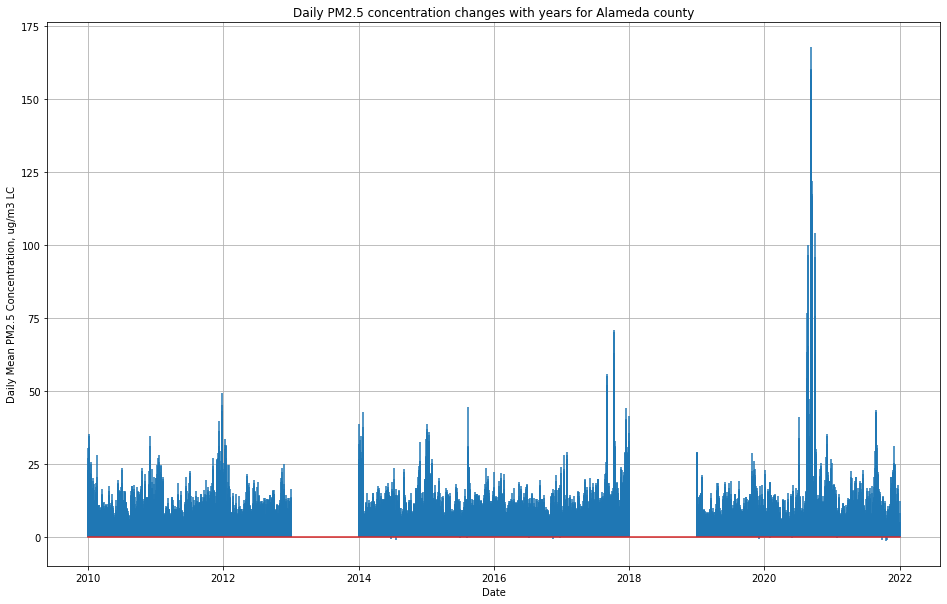

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt 
plt.figure(figsize = (16, 10))
plt.stem(Alameda_df_unique['Date'], Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'], markerfmt=' ')
plt.xlabel('Date')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Daily PM2.5 concentration changes with years for Alameda county")
plt.grid()

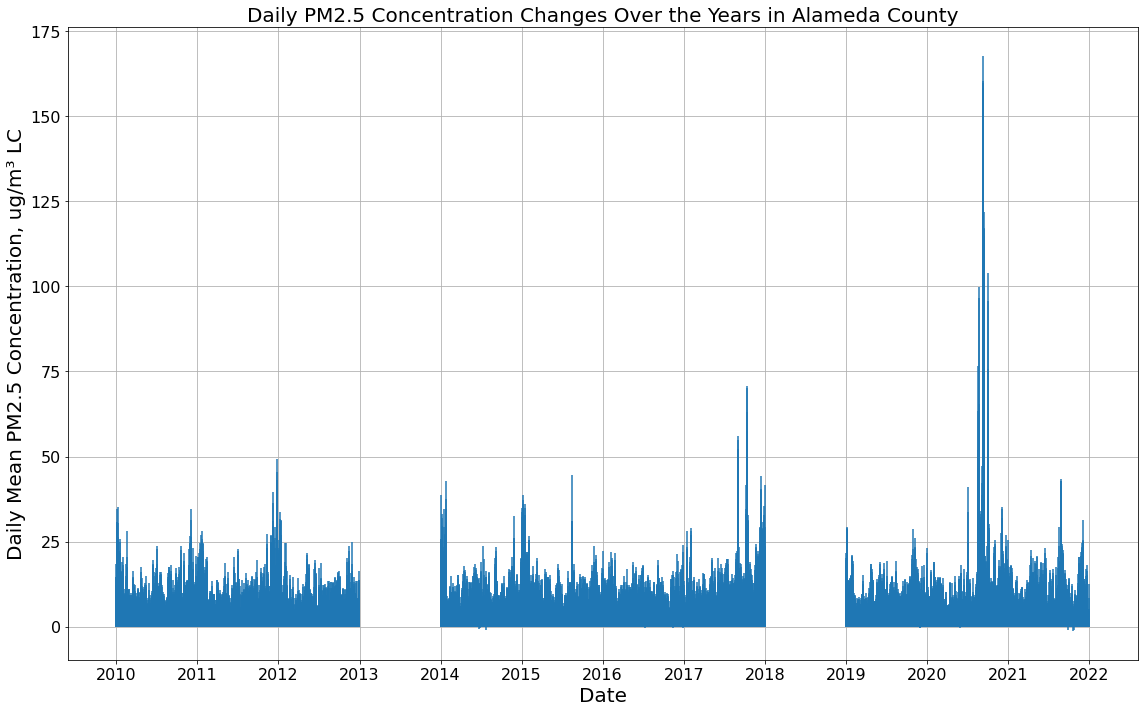

In [349]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Create a figure and set its size
plt.figure(figsize=(16, 10))

# Create a stem plot
plt.stem(
    Alameda_df_unique['Date'],
    Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'],
    markerfmt=' ',
    basefmt=' '  # No baseline for stems
)

# Beautify the x-axis by formatting dates
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Set x and y labels with larger font size
plt.xlabel('Date', fontsize=20)
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m³ LC', fontsize=20)

# Set the title with a larger font size
plt.title("Daily PM2.5 Concentration Changes Over the Years in Alameda County", fontsize=20)

# Show grid lines
plt.grid(True)

# Increase the font size of x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Save the plot to a PDF file
plt.savefig("Presentation/Daily PM2.5 Concentration Changes Over the Years in Alameda County.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.tight_layout()
plt.show()


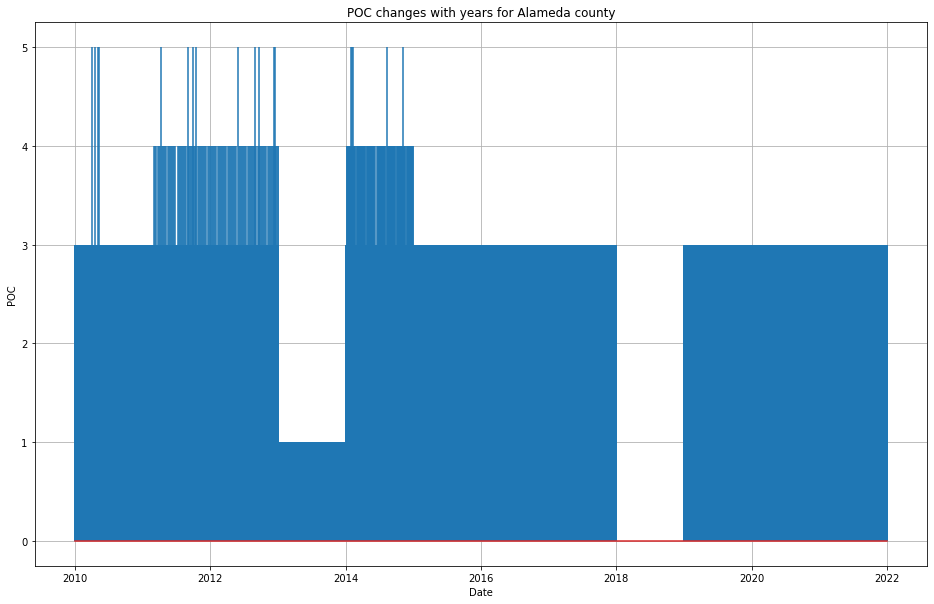

In [23]:
plt.figure(figsize = (16, 10))
plt.stem(Alameda_df_unique['Date'], Alameda_df_unique['POC'], markerfmt=' ')
plt.xlabel('Date')
plt.ylabel('POC')
plt.title("POC changes with years for Alameda county")
plt.grid()

<AxesSubplot: ylabel='Density'>

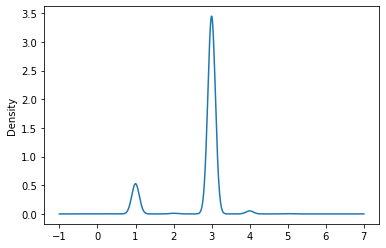

In [24]:
Alameda_df_unique['POC'].plot(kind='kde')

In [25]:
Alameda_df_unique['POC'].value_counts()

3.0    14593
1.0     2231
4.0      226
2.0       48
5.0       18
Name: POC, dtype: int64

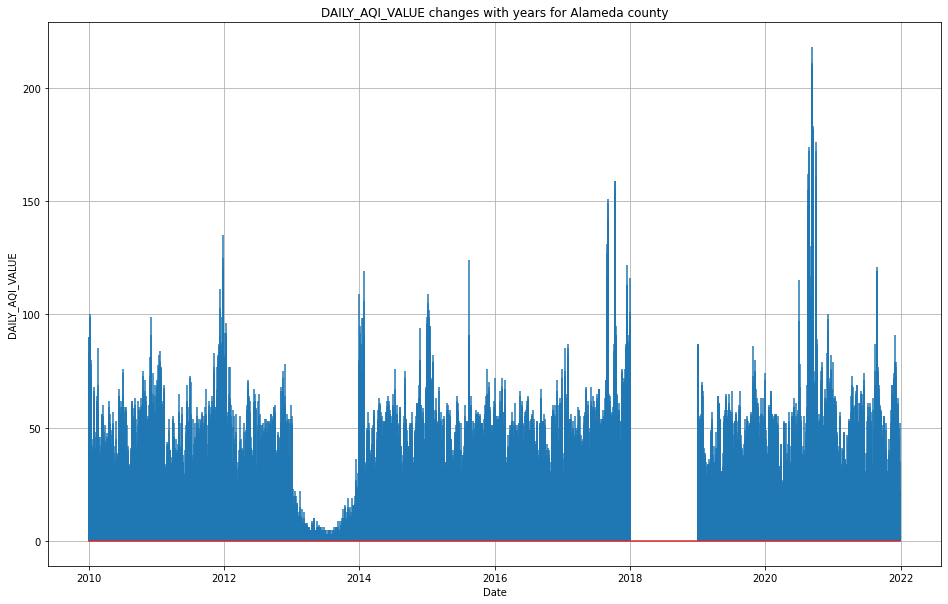

In [26]:
plt.figure(figsize = (16, 10))
plt.stem(Alameda_df_unique['Date'], Alameda_df_unique['DAILY_AQI_VALUE'], markerfmt=' ')
plt.xlabel('Date')
plt.ylabel('DAILY_AQI_VALUE')
plt.title("DAILY_AQI_VALUE changes with years for Alameda county")
plt.grid()

In [27]:
Alameda_df_unique['PERCENT_COMPLETE'].describe()

count    17116.000000
mean        99.895478
std          2.169504
min         21.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: PERCENT_COMPLETE, dtype: float64

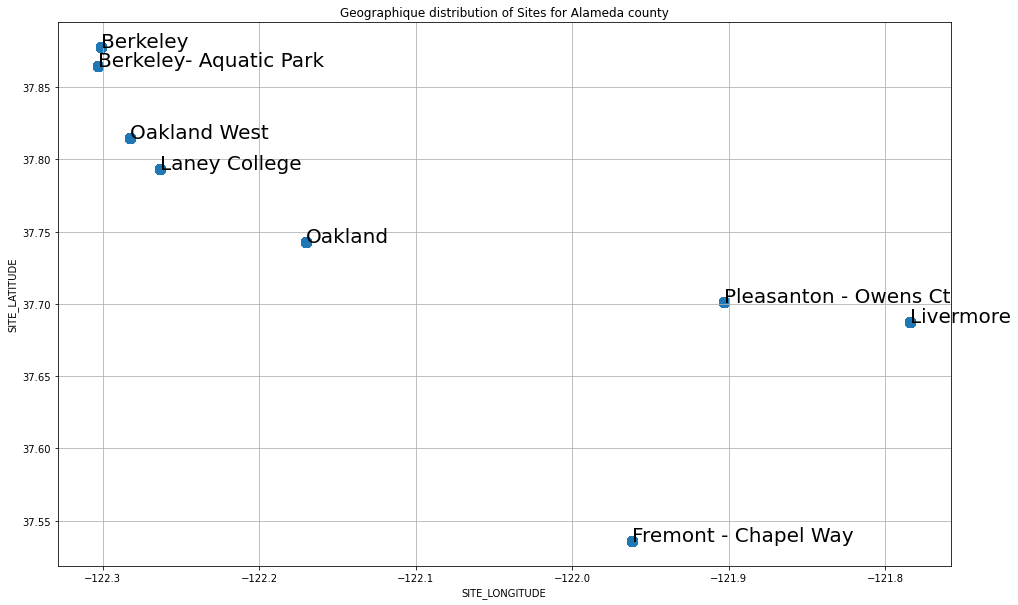

In [28]:
y = Alameda_df_unique['SITE_LATITUDE'].unique()
x = Alameda_df_unique['SITE_LONGITUDE'].unique()
n = Alameda_df_unique['Site Name'].unique()

plt.figure(figsize = (16, 10))
plt.scatter(Alameda_df_unique['SITE_LONGITUDE'], Alameda_df_unique['SITE_LATITUDE'], s = 100)
plt.ylabel('SITE_LATITUDE')
plt.xlabel('SITE_LONGITUDE')
plt.title("Geographique distribution of Sites for Alameda county")
plt.grid()
plt.savefig("Geographique distribution of Sites for Alameda county.pdf", format="pdf", bbox_inches="tight")


for i, txt in enumerate(n):
    plt.annotate(txt, (x[i], y[i]), fontsize=20)
    
plt.savefig("Geographique distribution of Sites for Alameda county.pdf", format="pdf", bbox_inches="tight")

In [241]:
Alameda_df_unique['Year'] = pd.DatetimeIndex(Alameda_df_unique['Date']).year

In [242]:
Alameda_PM25_years = Alameda_df_unique[['Year','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Year')).mean()
Alameda_PM25_years

Daily Mean PM2.5 Concentration, ug/m3 LC
Year                                          
2010                                  8.243717
2011                                  9.427484
2012                                  7.771989
2013                                       NaN
2014                                  8.450572
2015                                  9.290788
2016                                  7.655541
2017                                 10.324092
2019                                  7.329481
2020                                 10.967346
2021                                  8.437021

In [243]:
Alameda_df_unique[Alameda_df_unique['Year']==2013]['Daily Mean PM2.5 Concentration, ug/m3 LC'].isna().all()

True

In [244]:
Alameda_PM25_years.drop([2013], inplace = True)
Alameda_PM25_years

Daily Mean PM2.5 Concentration, ug/m3 LC
Year                                          
2010                                  8.243717
2011                                  9.427484
2012                                  7.771989
2014                                  8.450572
2015                                  9.290788
2016                                  7.655541
2017                                 10.324092
2019                                  7.329481
2020                                 10.967346
2021                                  8.437021

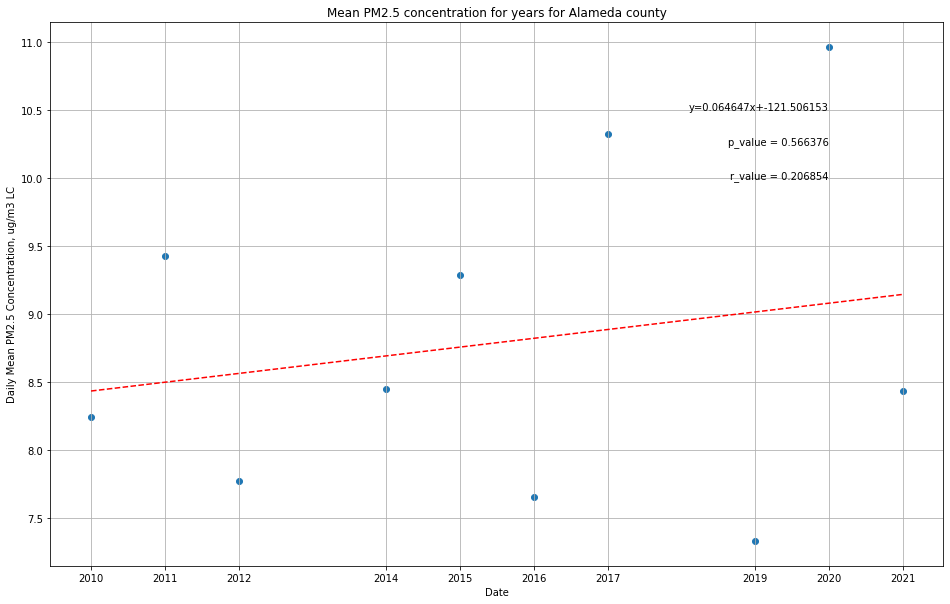

In [33]:
plt.figure(figsize = (16, 10))
plt.scatter(Alameda_PM25_years.index, Alameda_PM25_years['Daily Mean PM2.5 Concentration, ug/m3 LC'])
plt.xticks(Alameda_PM25_years.index)
plt.xlabel('Date')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Mean PM2.5 concentration for years for Alameda county")
plt.grid()

z = np.polyfit(Alameda_PM25_years.index, Alameda_PM25_years['Daily Mean PM2.5 Concentration, ug/m3 LC'], 1)
p = np.poly1d(z)
plt.plot(Alameda_PM25_years.index,p(Alameda_PM25_years.index),"r--")


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Alameda_PM25_years.index, Alameda_PM25_years['Daily Mean PM2.5 Concentration, ug/m3 LC'])

plt.text(2020, 10.5,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
plt.text(2020, 10.25,"p_value = %.6f"%p_value, ha='right') 
plt.text(2020,10,"r_value = %.6f"%r_value, ha = "right")

plt.savefig("Mean PM2.5 concentration for years for Alameda county.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [245]:
Alameda_df_unique['Year_Month'] = pd.DatetimeIndex(Alameda_df_unique['Date']).to_period('M')

In [246]:
Alameda_PM25_years_months = Alameda_df_unique[['Year_Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Year_Month')).mean()
Alameda_PM25_years_months

Daily Mean PM2.5 Concentration, ug/m3 LC
Year_Month                                          
2010-01                                    12.480068
2010-02                                     7.647857
2010-03                                     6.781579
2010-04                                     6.418794
2010-05                                     5.913265
...                                              ...
2021-08                                    11.671978
2021-09                                    10.543429
2021-10                                     5.789610
2021-11                                    10.334667
2021-12                                     8.440000

[132 rows x 1 columns]

In [36]:
#Alameda_PM25_years_months.index=Alameda_PM25_years_months.index.to_series().astype(str)

In [37]:
'''plt.figure(figsize = (16, 10))
plt.scatter(Alameda_PM25_years_months.index, Alameda_PM25_years_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
plt.xticks(Alameda_PM25_years_months.index)
plt.xlabel('Date')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Mean PM2.5 concentration for years and months for Alameda county")
plt.grid()

z = np.polyfit(Alameda_PM25_years_months.index, Alameda_PM25_years_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 1)
p = np.poly1d(z)
plt.plot(Alameda_PM25_years_months.index,p(Alameda_PM25_years_months.index),"r--")


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Alameda_PM25_years_months.index, Alameda_PM25_years_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])

plt.text(2020, 10.5,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
plt.text(2020, 10.25,"p_value = %.6f"%p_value, ha='right') 
plt.text(2020,10,"r_value = %.6f"%r_value, ha = "right")

plt.savefig("Mean PM2.5 concentration for years and months for Alameda county.pdf", format="pdf", bbox_inches="tight")
plt.show()'''

'plt.figure(figsize = (16, 10))\nplt.scatter(Alameda_PM25_years_months.index, Alameda_PM25_years_months[\'Daily Mean PM2.5 Concentration, ug/m3 LC\'])\nplt.xticks(Alameda_PM25_years_months.index)\nplt.xlabel(\'Date\')\nplt.ylabel(\'Daily Mean PM2.5 Concentration, ug/m3 LC\')\nplt.title("Mean PM2.5 concentration for years and months for Alameda county")\nplt.grid()\n\nz = np.polyfit(Alameda_PM25_years_months.index, Alameda_PM25_years_months[\'Daily Mean PM2.5 Concentration, ug/m3 LC\'], 1)\np = np.poly1d(z)\nplt.plot(Alameda_PM25_years_months.index,p(Alameda_PM25_years_months.index),"r--")\n\n\nslope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Alameda_PM25_years_months.index, Alameda_PM25_years_months[\'Daily Mean PM2.5 Concentration, ug/m3 LC\'])\n\nplt.text(2020, 10.5,"y=%.6fx+%.6f"%(z[0],z[1]), ha=\'right\') \nplt.text(2020, 10.25,"p_value = %.6f"%p_value, ha=\'right\') \nplt.text(2020,10,"r_value = %.6f"%r_value, ha = "right")\n\nplt.savefig("Mean PM2.5 concentrat

In [247]:
Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'].fillna(value=Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean())

0        11.8
1        14.5
2        18.5
3        12.2
4        14.7
         ... 
17111     3.0
17112    12.5
17113     8.3
17114     4.7
17115     5.2
Name: Daily Mean PM2.5 Concentration, ug/m3 LC, Length: 17116, dtype: float64

In [248]:
Alameda_df_unique['Month'] = Alameda_df_unique['Date'].dt.month

In [249]:
Alameda_df_unique['Month'] = pd.DatetimeIndex(Alameda_df_unique['Date']).month

In [250]:
Alameda_df_unique

Date              Site Name  POC  \
0     2010-01-01               Berkeley  1.0   
1     2010-01-01   Fremont - Chapel Way  3.0   
2     2010-01-01              Livermore  1.0   
3     2010-01-01                Oakland  3.0   
4     2010-01-01           Oakland West  1.0   
...          ...                    ...  ...   
17111 2021-12-31          Laney College  3.0   
17112 2021-12-31              Livermore  3.0   
17113 2021-12-31                Oakland  3.0   
17114 2021-12-31           Oakland West  3.0   
17115 2021-12-31  Pleasanton - Owens Ct  3.0   

       Daily Mean PM2.5 Concentration, ug/m3 LC  DAILY_AQI_VALUE  \
0                                          11.8             49.0   
1                                          14.5             56.0   
2                                          18.5             64.0   
3                                          12.2             51.0   
4                                          14.7             56.0   
...                                         ...              ...   
17111                                       3.0             13.0   
17112                                      12.5             52.0   
17113                                       8.3             35.0   
17114                                       4.7             20.0   
17115                                       5.2             22.0   

       PERCENT_COMPLETE  SITE_LATITUDE  SITE_LONGITUDE  \
0                 100.0      37.877794     -122.301290   
1                 100.0      37.535833     -121.961823   
2                 100.0      37.687526     -121.784217   
3                 100.0      37.743065     -122.169935   
4                 100.0      37.814781     -122.282347   
...                 ...            ...             ...   
17111             100.0      37.793624     -122.263376   
17112             100.0      37.687526     -121.784217   
17113             100.0      37.743065     -122.169935   
17114             100.0      37.814781     -122.282347   
17115             100.0      37.701222     -121.903019   

       Daily Max 8-hour CO Concentration  Year Year_Month  Month  
0                                    NaN  2010    2010-01      1  
1                                    NaN  2010    2010-01      1  
2                                    NaN  2010    2010-01      1  
3                                    NaN  2010    2010-01      1  
4                                    NaN  2010    2010-01      1  
...                                  ...   ...        ...    ...  
17111                                NaN  2021    2021-12     12  
17112                                NaN  2021    2021-12     12  
17113                                NaN  2021    2021-12     12  
17114                                NaN  2021    2021-12     12  
17115                                NaN  2021    2021-12     12  

[17116 rows x 12 columns]

In [251]:
Alameda_PM25_months = Alameda_df_unique[['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()
Alameda_PM25_months

Daily Mean PM2.5 Concentration, ug/m3 LC
Month                                          
1                                     11.165103
2                                      7.314906
3                                      6.257601
4                                      7.131855
5                                      7.367359
6                                      7.798493
7                                      7.616353
8                                      9.408509
9                                     12.572676
10                                     9.353571
11                                     9.671246
12                                    10.480438

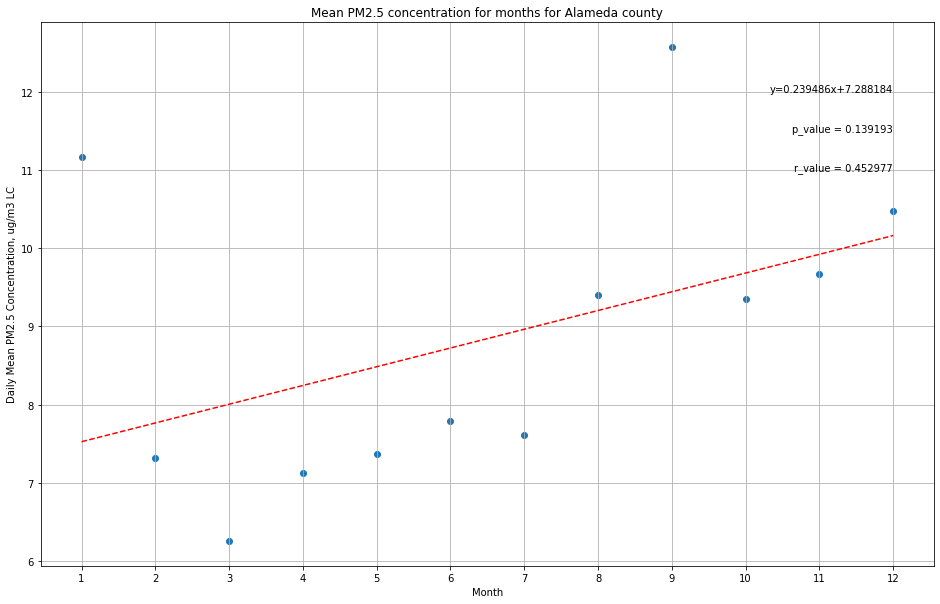

In [43]:
plt.figure(figsize = (16, 10))
plt.scatter(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
#plt.scatter([1,9], [Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][1], 
#            Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][9]], c = 'red')
plt.xticks(Alameda_PM25_months.index)
plt.xlabel('Month')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Mean PM2.5 concentration for months for Alameda county")
plt.grid()

z = np.polyfit(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 1)
p = np.poly1d(z)
plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

#idx = [2,3,4,5,6,7,8,10,11,12]
#z = np.polyfit(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]], 1)
#p = np.poly1d(z)
#plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]])

# Define the confidence interval
#ci = 1.96 * np.std(p(Alameda_PM25_months.index)) / np.mean(p(Alameda_PM25_months.index))
#plt.fill_between(Alameda_PM25_months.index, (p(Alameda_PM25_months.index)-ci), (p(Alameda_PM25_months.index)+ci), color='blue', alpha=0.5)

plt.text(12,12,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
plt.text(12,11.5,"p_value = %.6f"%p_value, ha='right') 
plt.text(12,11,"r_value = %.6f"%r_value, ha = "right")

plt.savefig("Air_Pollution_plots/Mean_PM2.5_concentration_for_months_for_counties/Mean PM2.5 concentration for months for Alameda county.pdf", format="pdf", bbox_inches="tight")
plt.show()

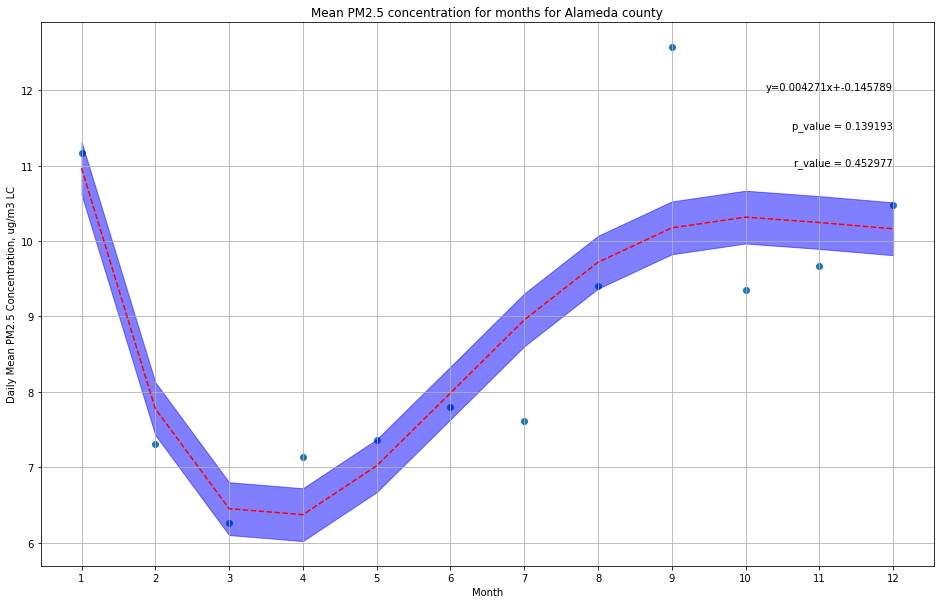

In [104]:
plt.figure(figsize = (16, 10))
plt.scatter(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
#plt.scatter([1,9], [Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][1], 
#            Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][9]], c = 'red')
plt.xticks(Alameda_PM25_months.index)
plt.xlabel('Month')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Mean PM2.5 concentration for months for Alameda county")
plt.grid()

z = np.polyfit(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 4)
p = np.poly1d(z)
plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

#idx = [2,3,4,5,6,7,8,10,11,12]
#z = np.polyfit(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]], 1)
#p = np.poly1d(z)
#plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
#slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]])

#Define the confidence interval
ci = 1.96 * np.std(p(Alameda_PM25_months.index)) / np.mean(p(Alameda_PM25_months.index))
plt.fill_between(Alameda_PM25_months.index, (p(Alameda_PM25_months.index)-ci), (p(Alameda_PM25_months.index)+ci), color='blue', alpha=0.5)

plt.text(12,12,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
plt.text(12,11.5,"p_value = %.6f"%p_value, ha='right') 
plt.text(12,11,"r_value = %.6f"%r_value, ha = "right")

plt.savefig("Air_Pollution_plots/Mean_PM2.5_concentration_for_months_for_counties/Trend_3/Mean PM2.5 concentration for months for Alameda county with polinomial trend 3.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [103]:
for i in [1,2,3,4,5]:
    
    z = np.polyfit(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], i)
    p = np.poly1d(z)
    # Calculate R-squared
    from sklearn.metrics import r2_score
    r_squared = r2_score(Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], p(Alameda_PM25_months.index))

    # Calculate Mean Squared Error (MSE)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], p(Alameda_PM25_months.index))

    print(i, r_squared, mse)

1 0.20518831613095923 2.6474403259542645
2 0.356767033240468 2.14254637890171
3 0.7063532991926087 0.9781085671974176
4 0.7493213148654763 0.8349862909057073
5 0.7500844422377431 0.832444387936511


In [45]:
Livermore_PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == "Livermore"][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()
Livermore_PM25_months

Daily Mean PM2.5 Concentration, ug/m3 LC
Month                                          
1                                     11.326461
2                                      6.625926
3                                      5.081452
4                                      5.497466
5                                      5.701639
6                                      6.164833
7                                      6.802597
8                                      9.346689
9                                     10.789114
10                                     7.471569
11                                     9.452000
12                                    10.735354

In [46]:
n = Alameda_df_unique['Site Name'].unique()
n

array(['Berkeley', 'Fremont - Chapel Way', 'Livermore', 'Oakland',
       'Oakland West', 'Laney College', 'Berkeley- Aquatic Park',
       'Pleasanton - Owens Ct'], dtype=object)

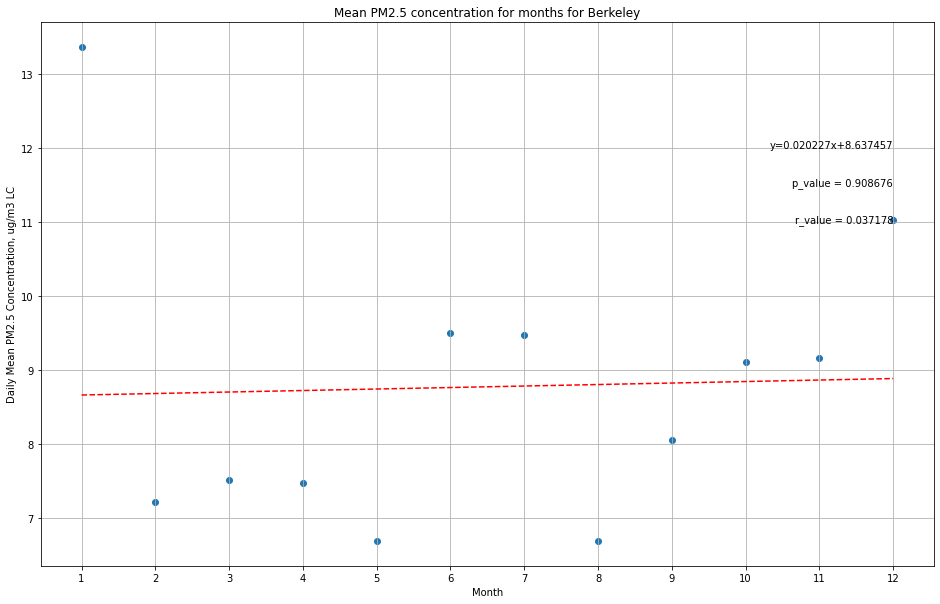

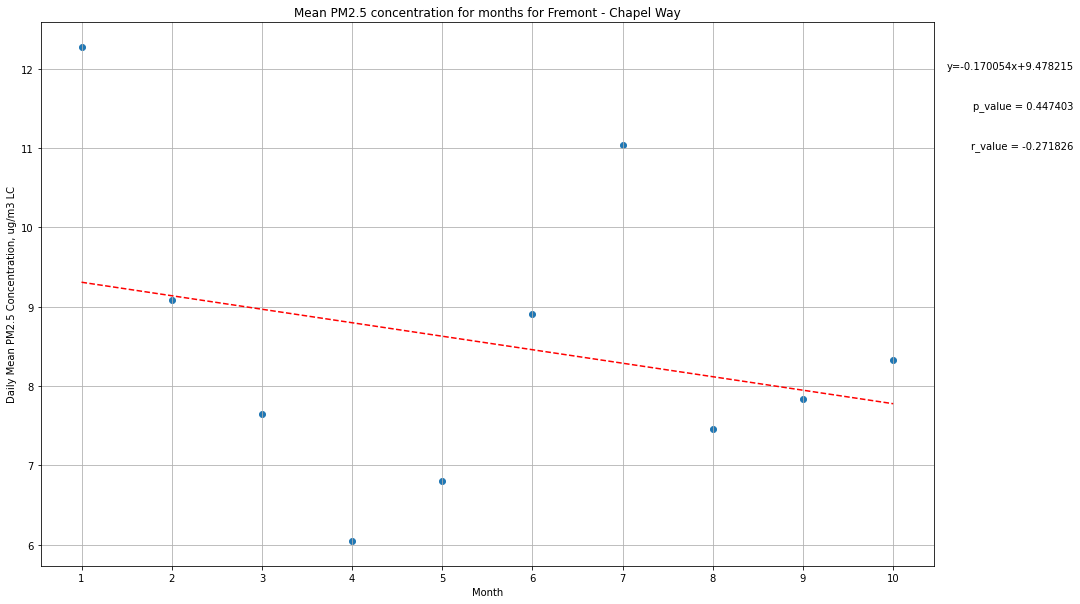

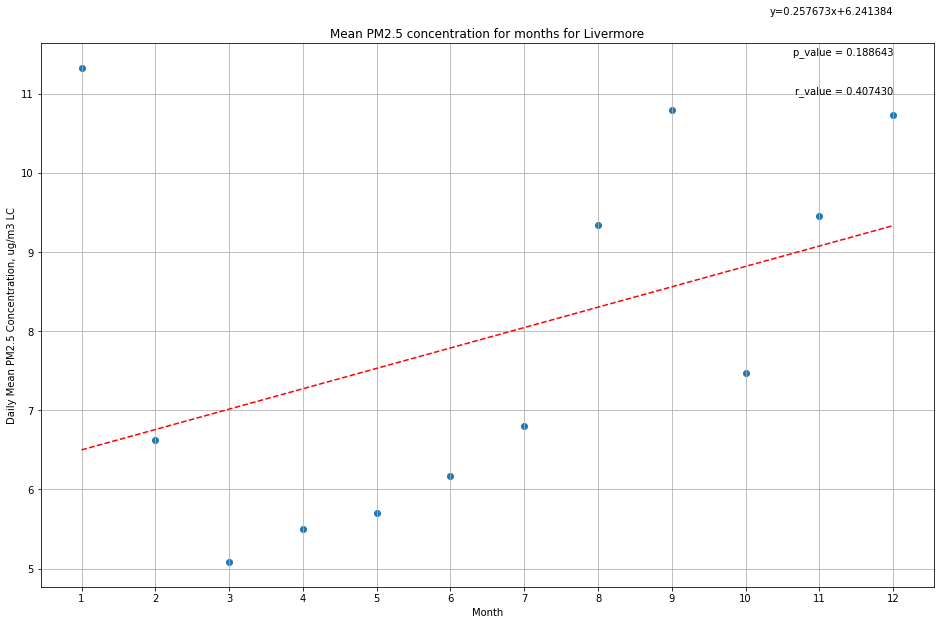

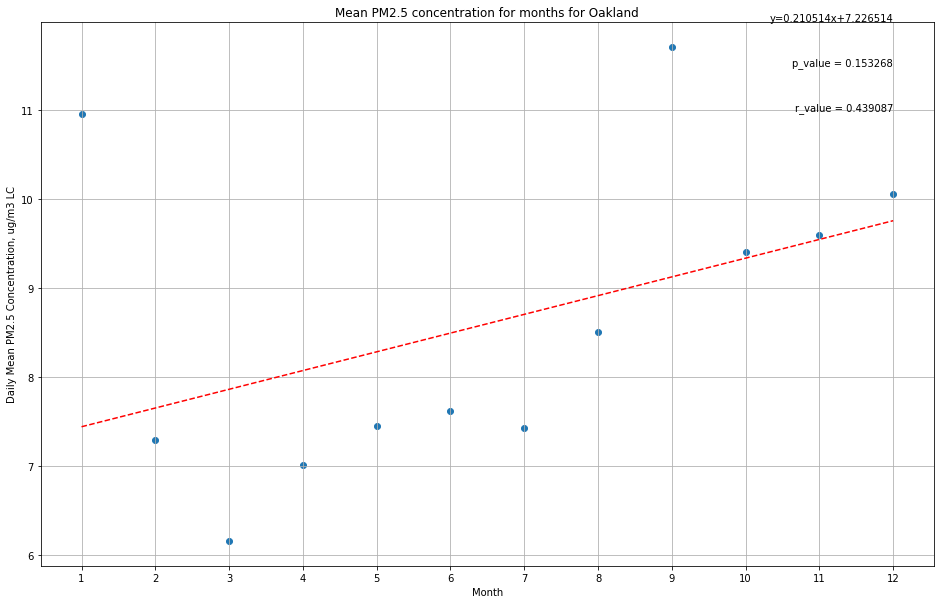

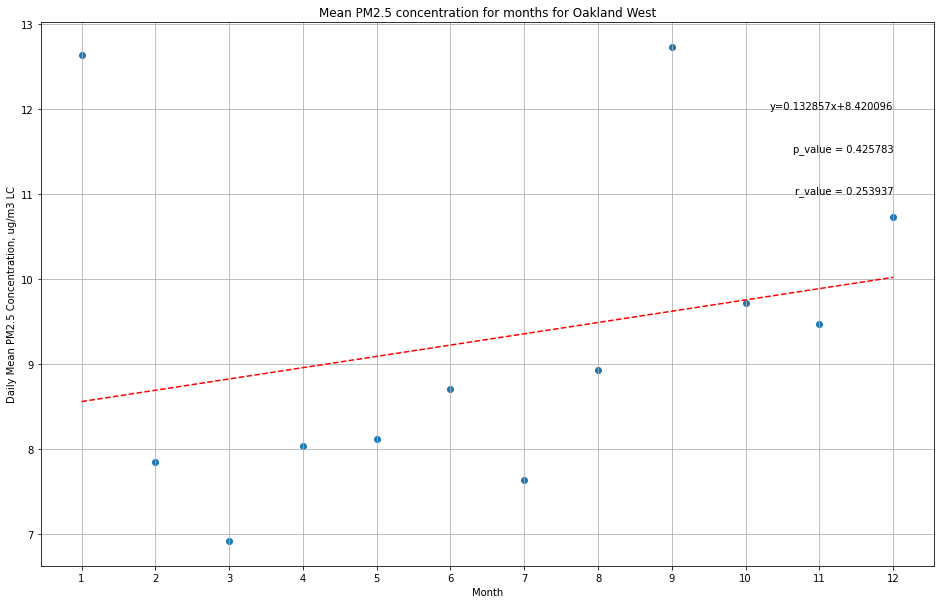

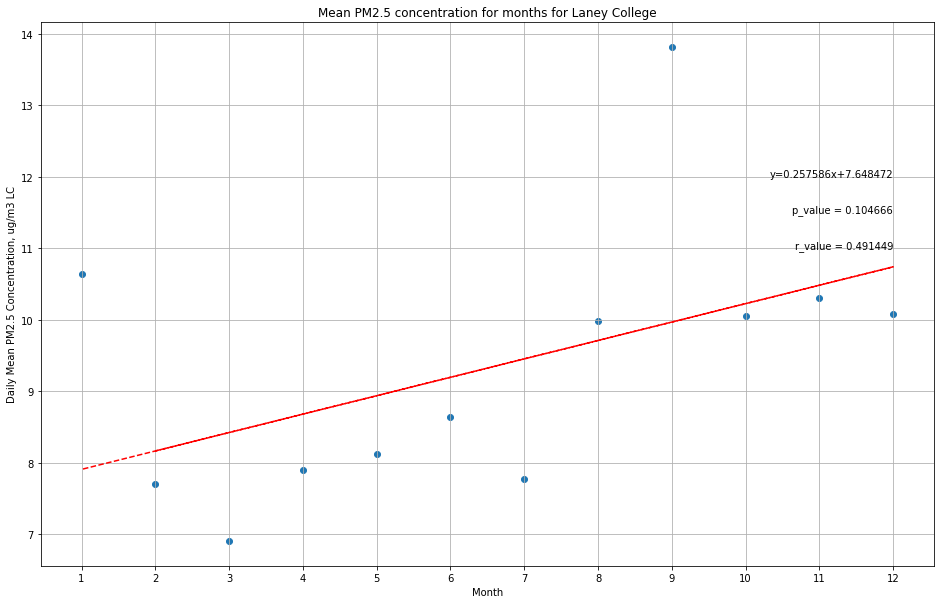

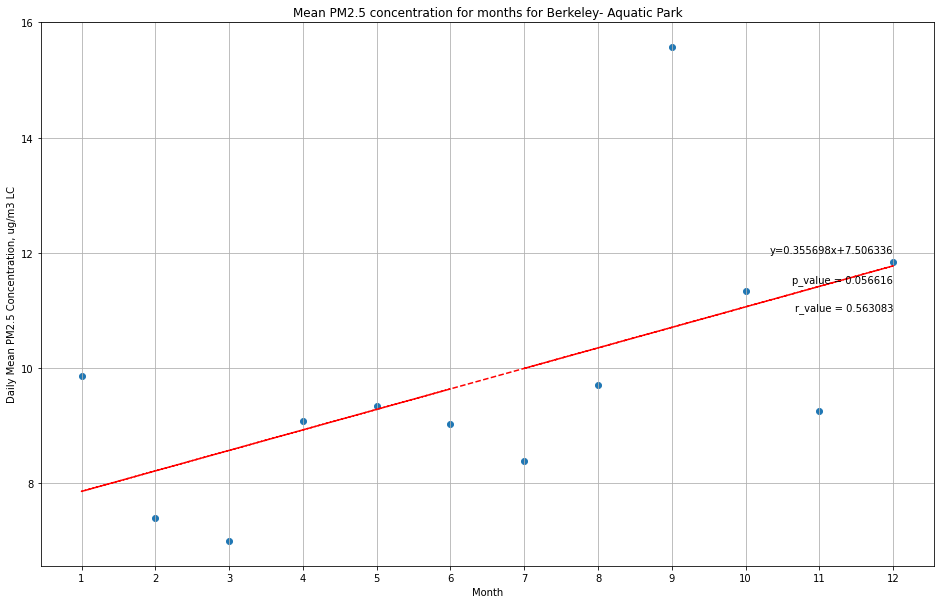

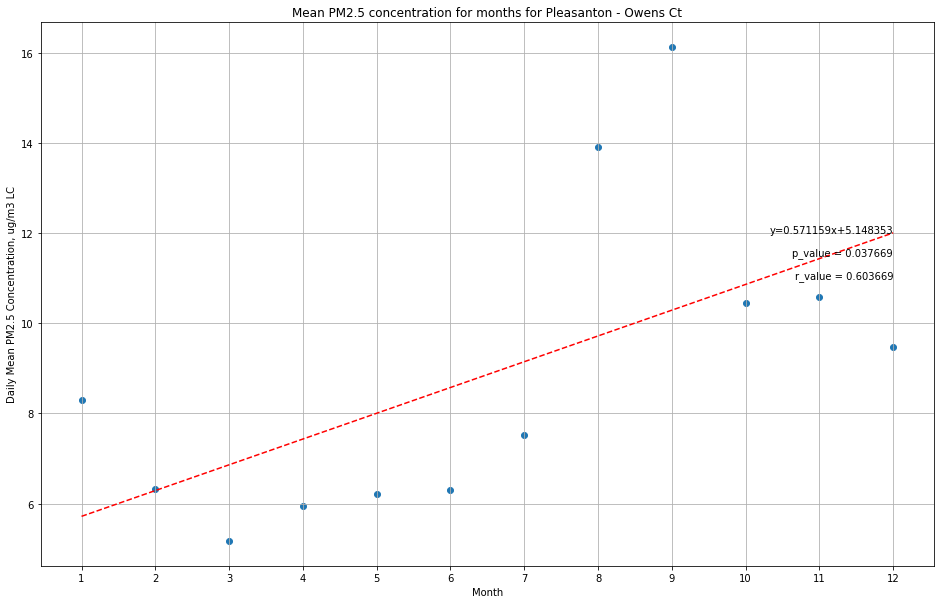

In [47]:
n = Alameda_df_unique['Site Name'].unique()

for i in n:
    
    PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()

    plt.figure(figsize = (16, 10))
    plt.scatter(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
    #plt.scatter([1,9], [Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][1], 
    #            Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][9]], c = 'red')
    plt.xticks(PM25_months.index)
    plt.xlabel('Month')
    plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
    plt.title("Mean PM2.5 concentration for months for " + i)
    plt.grid()

    z = np.polyfit(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 1)
    p = np.poly1d(z)
    plt.plot(PM25_months.index,p(PM25_months.index),"r--")
    #idx = [2,3,4,5,6,7,8,10,11,12]
    #z = np.polyfit(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]], 1)
    #p = np.poly1d(z)
    #plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
    #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]])

    # Define the confidence interval
    #ci = 1.96 * np.std(p(Alameda_PM25_months.index)) / np.mean(p(Alameda_PM25_months.index))
    #plt.fill_between(Alameda_PM25_months.index, (p(Alameda_PM25_months.index)-ci), (p(Alameda_PM25_months.index)+ci), color='blue', alpha=0.5)

    plt.text(12,12,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
    plt.text(12,11.5,"p_value = %.6f"%p_value, ha='right') 
    plt.text(12,11,"r_value = %.6f"%r_value, ha = "right")

    plt.savefig("Air_Pollution_plots/Mean_PM2.5_concentration_for_months_for_counties/Mean PM2.5 concentration for months for " + i +".pdf", format="pdf", bbox_inches="tight")
    plt.show()

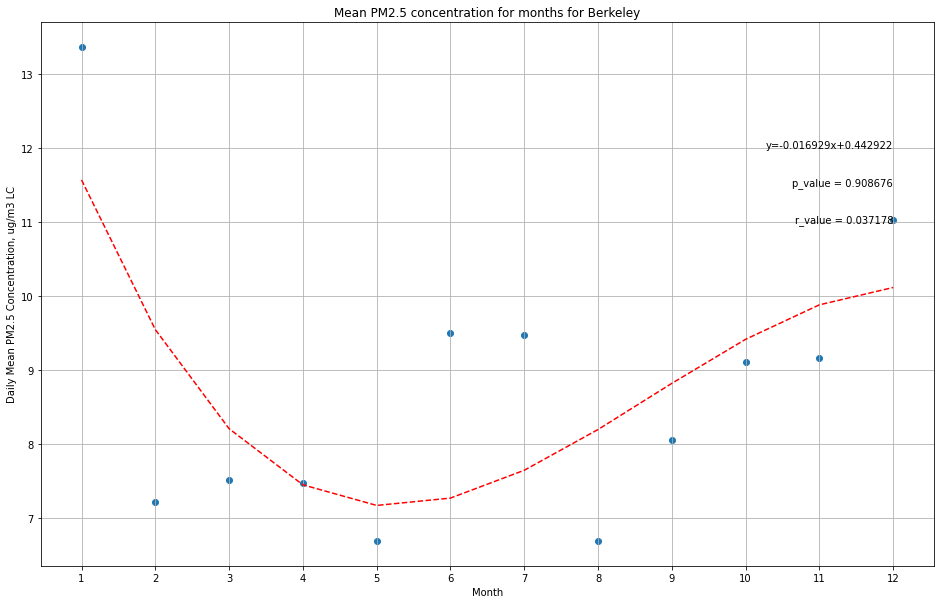

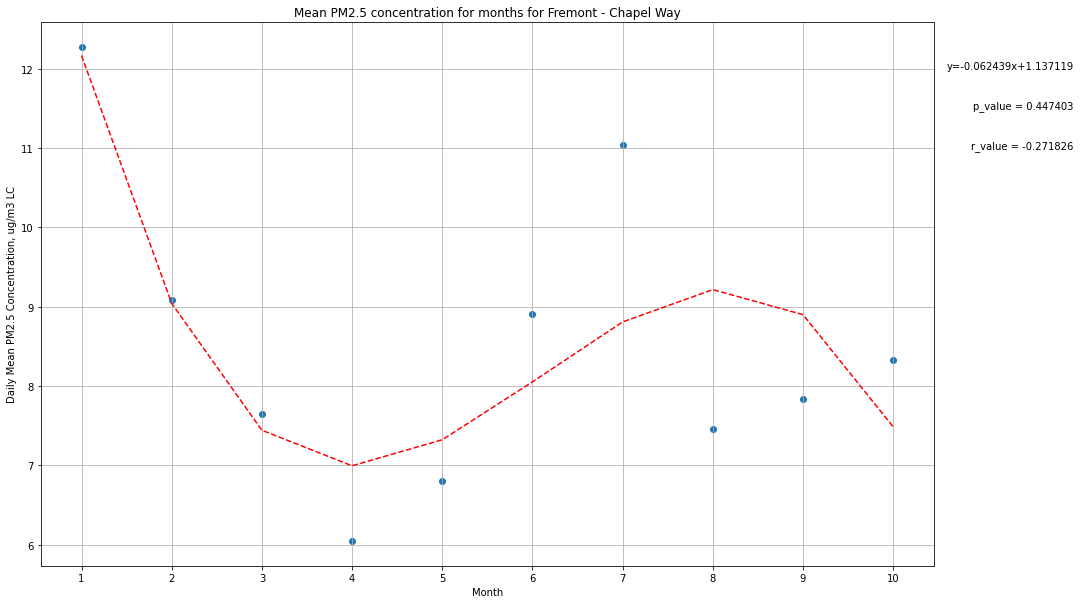

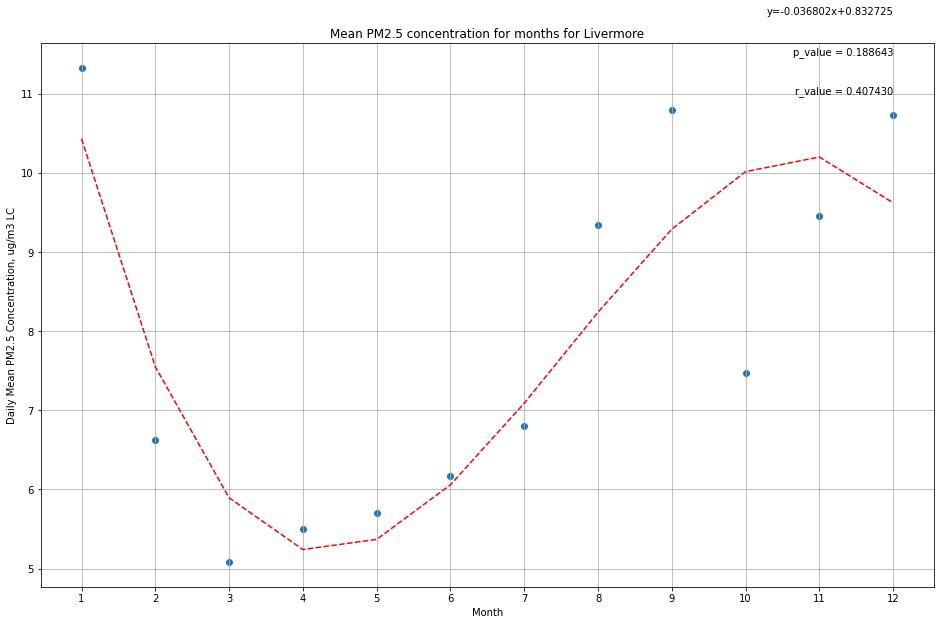

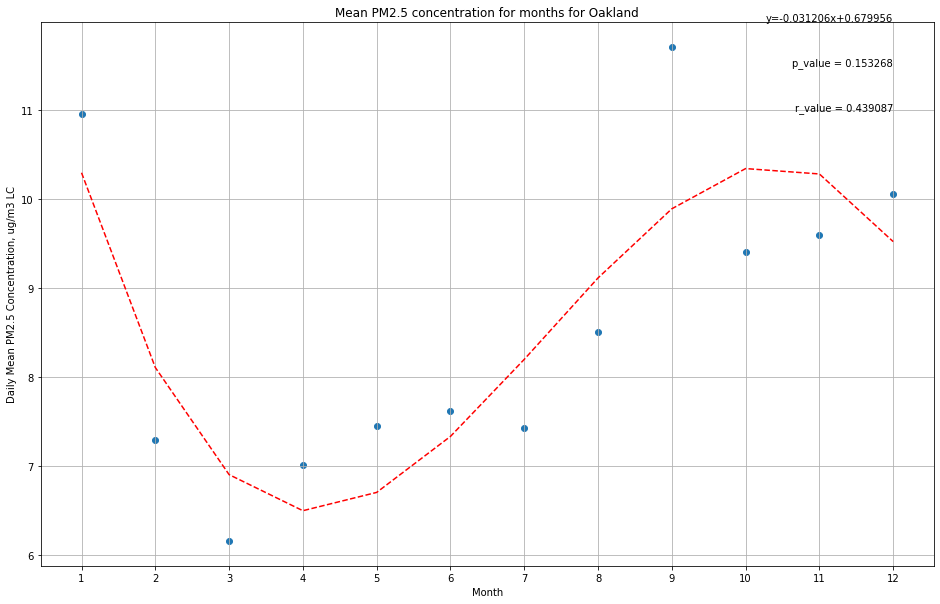

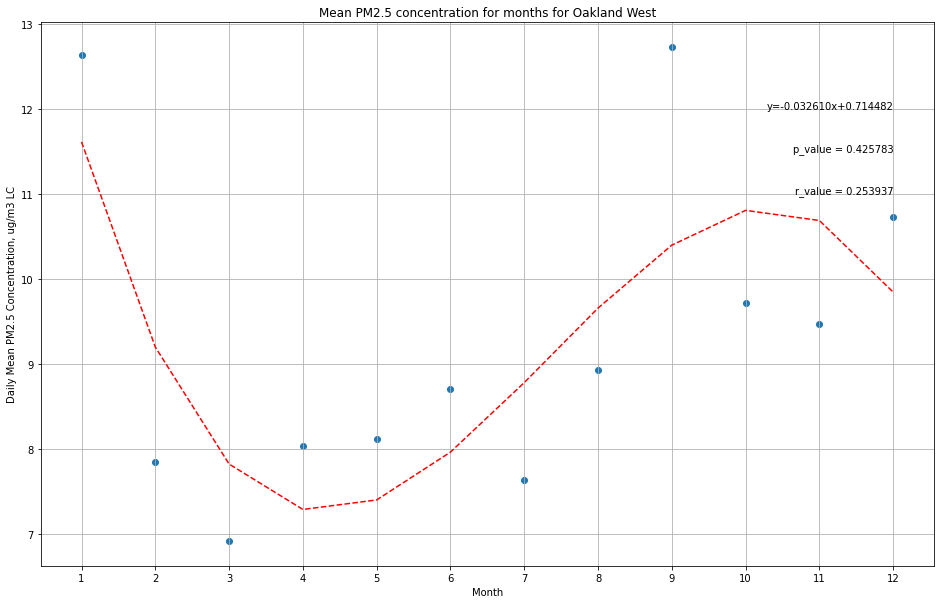

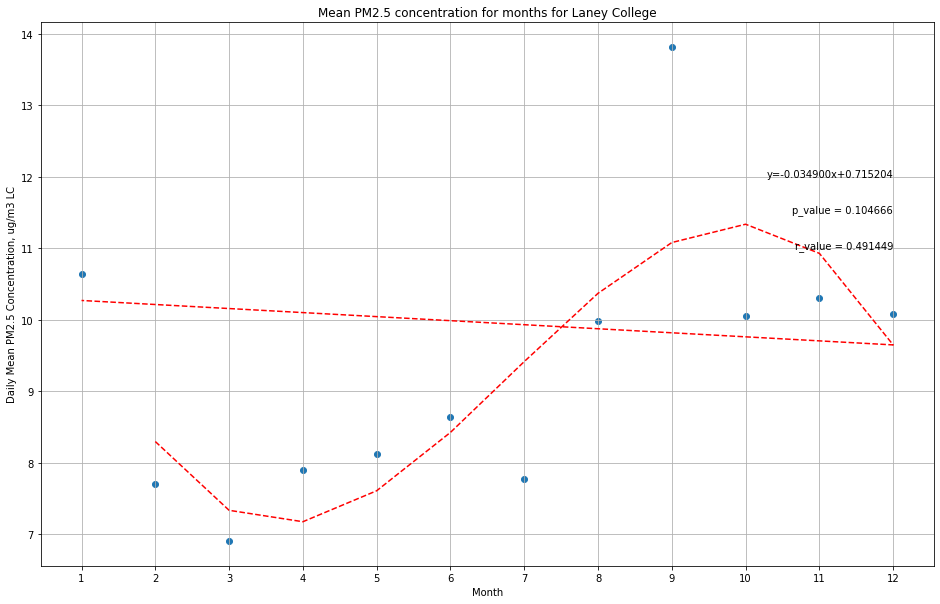

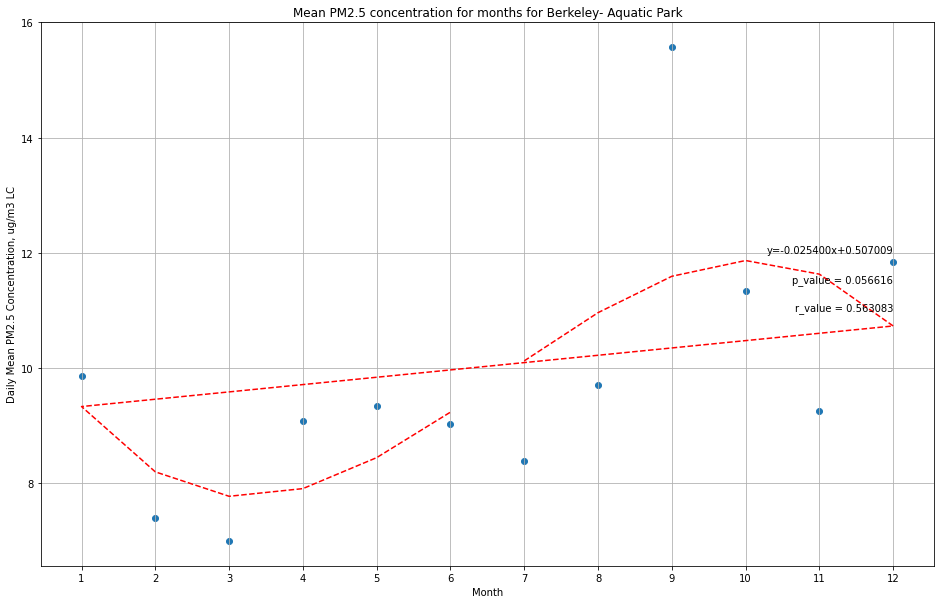

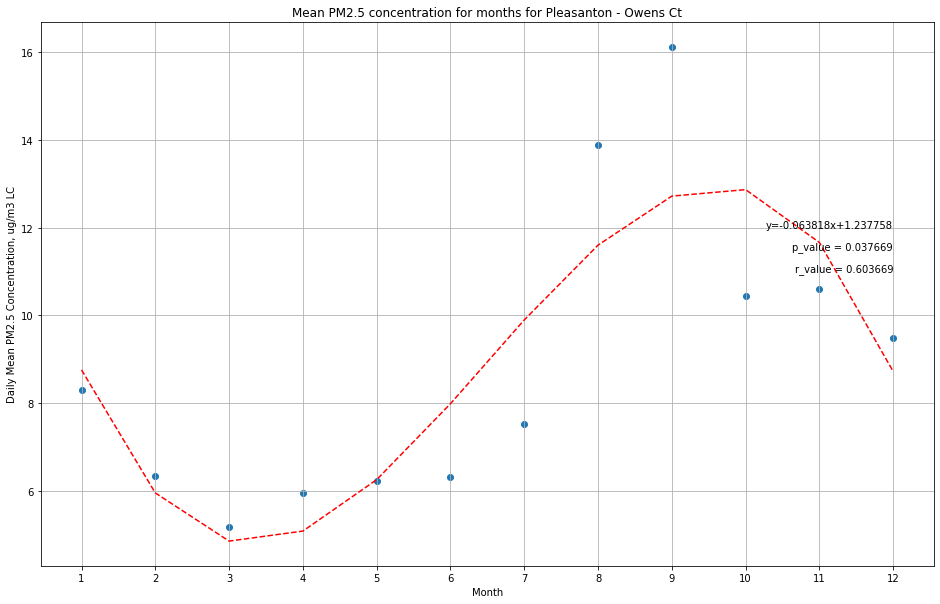

In [48]:
n = Alameda_df_unique['Site Name'].unique()

for i in n:
    
    PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()

    plt.figure(figsize = (16, 10))
    plt.scatter(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
    #plt.scatter([1,9], [Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][1], 
    #            Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][9]], c = 'red')
    plt.xticks(PM25_months.index)
    plt.xlabel('Month')
    plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
    plt.title("Mean PM2.5 concentration for months for " + i)
    plt.grid()

    z = np.polyfit(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 3)
    p = np.poly1d(z)
    plt.plot(PM25_months.index,p(PM25_months.index),"r--")
    #idx = [2,3,4,5,6,7,8,10,11,12]
    #z = np.polyfit(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]], 1)
    #p = np.poly1d(z)
    #plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
    #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]])

    # Define the confidence interval
    #ci = 1.96 * np.std(p(Alameda_PM25_months.index)) / np.mean(p(Alameda_PM25_months.index))
    #plt.fill_between(Alameda_PM25_months.index, (p(Alameda_PM25_months.index)-ci), (p(Alameda_PM25_months.index)+ci), color='blue', alpha=0.5)

    plt.text(12,12,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
    plt.text(12,11.5,"p_value = %.6f"%p_value, ha='right') 
    plt.text(12,11,"r_value = %.6f"%r_value, ha = "right")

    plt.savefig("Air_Pollution_plots/Mean_PM2.5_concentration_for_months_for_counties/Trend_3/Mean PM2.5 concentration for months for " + i +".pdf", format="pdf", bbox_inches="tight")
    plt.show()

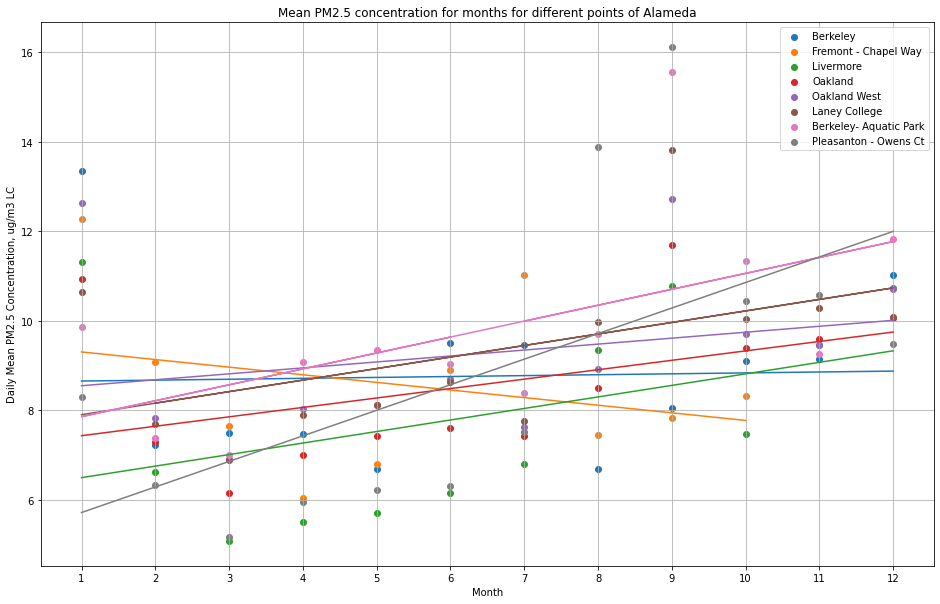

In [49]:
n = Alameda_df_unique['Site Name'].unique()

plt.figure(figsize = (16, 10))

for i in n:
    
    PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()

    plt.scatter(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], label = i)
    #plt.scatter([1,9], [Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][1], 
    #            Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][9]], c = 'red')


    z = np.polyfit(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 1)
    p = np.poly1d(z)
    plt.plot(PM25_months.index,p(PM25_months.index))
    #idx = [2,3,4,5,6,7,8,10,11,12]
    #z = np.polyfit(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]], 1)
    #p = np.poly1d(z)
    #plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

    #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(PM25_months.index, PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
    #slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(idx, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'].iloc[[i-1 for i in idx]])

    # Define the confidence interval
    #ci = 1.96 * np.std(p(Alameda_PM25_months.index)) / np.mean(p(Alameda_PM25_months.index))
    #plt.fill_between(Alameda_PM25_months.index, (p(Alameda_PM25_months.index)-ci), (p(Alameda_PM25_months.index)+ci), color='blue', alpha=0.5)

    #plt.text(12,12,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
    #plt.text(12,11.5,"p_value = %.6f"%p_value, ha='right') 
    #plt.text(12,11,"r_value = %.6f"%r_value, ha = "right")
plt.xticks(PM25_months.index)
plt.xlabel('Month')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Mean PM2.5 concentration for months for different points of Alameda")
plt.grid()
plt.legend()

plt.savefig("Mean PM2.5 concentration for months for different points of Alameda.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [252]:
PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == 'Fremont - Chapel Way'][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()
PM25_months

Daily Mean PM2.5 Concentration, ug/m3 LC
Month                                          
1                                     12.273077
2                                      9.078571
3                                      7.648387
4                                      6.046667
5                                      6.809677
6                                      8.913793
7                                     11.032258
8                                      7.457692
9                                      7.840000
10                                     8.329032

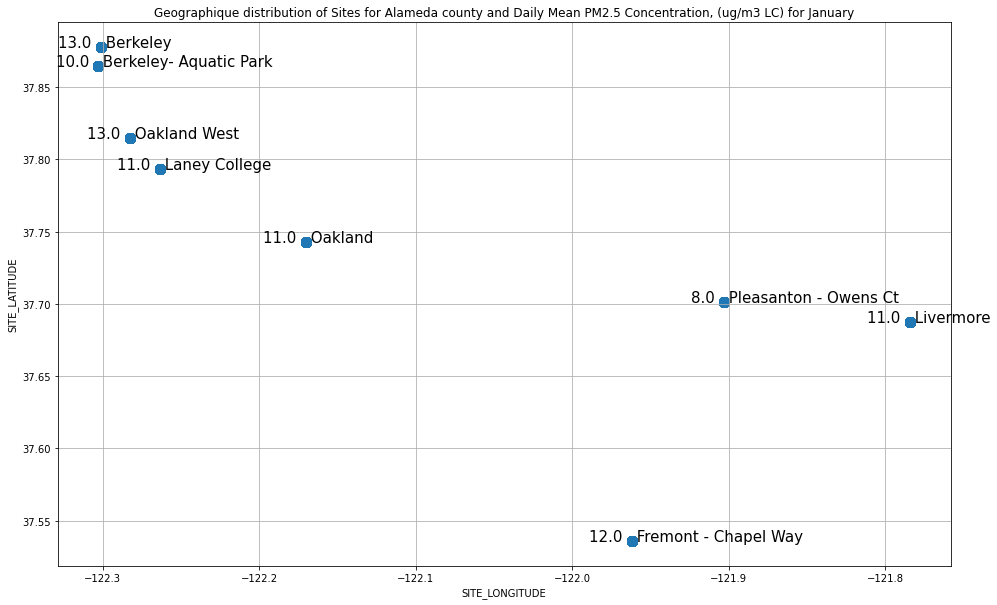

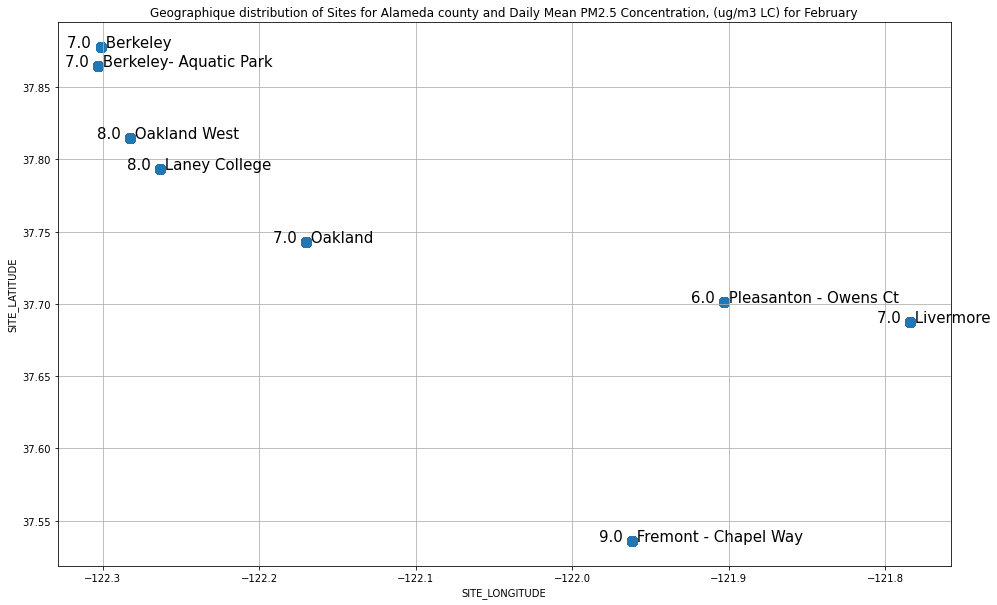

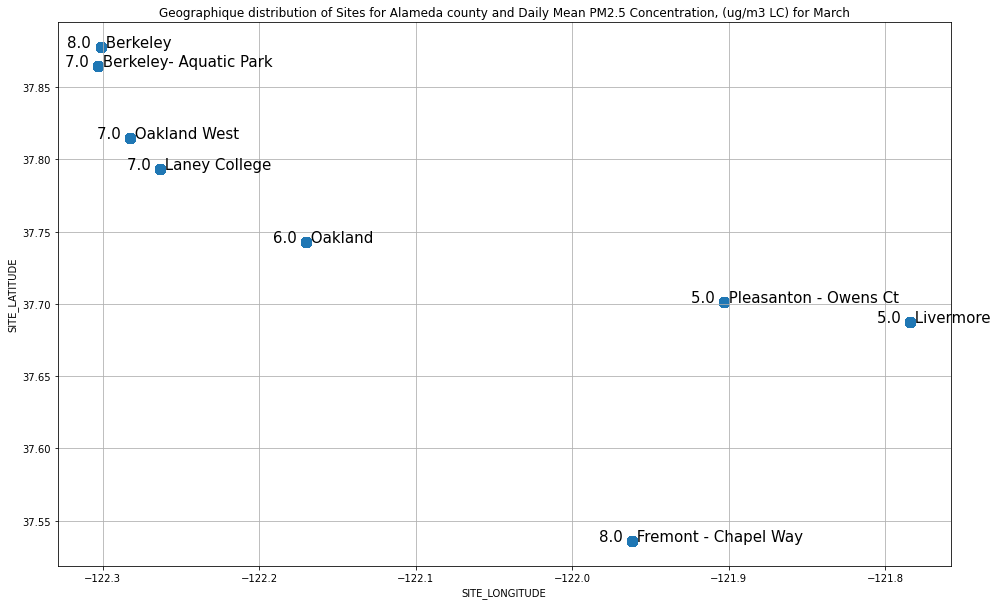

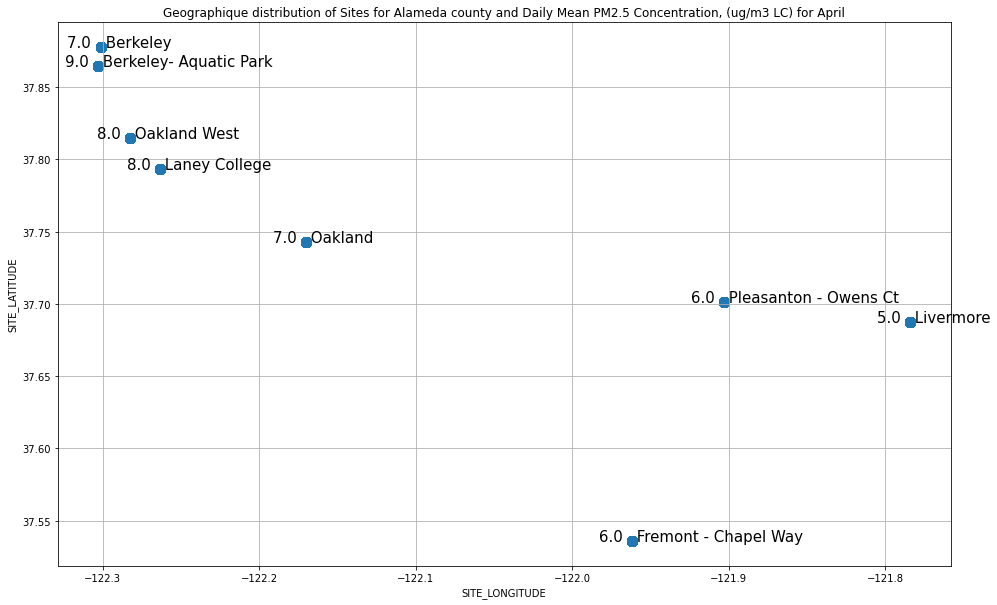

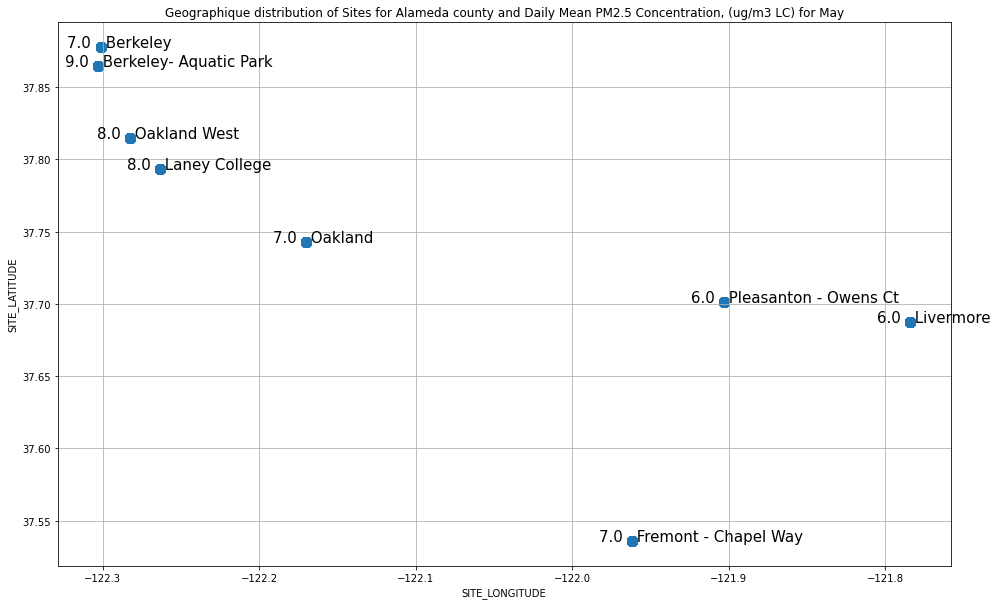

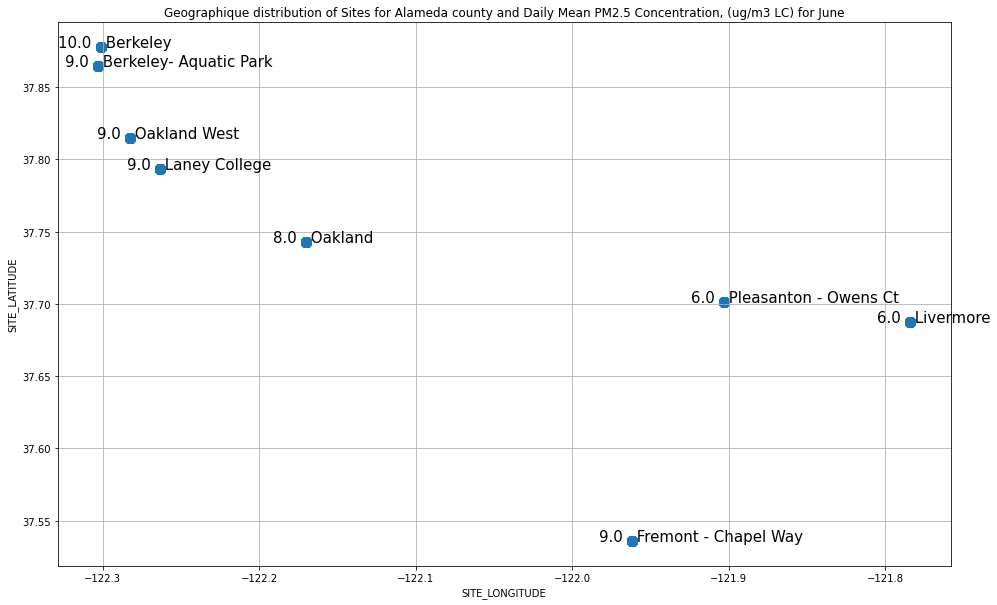

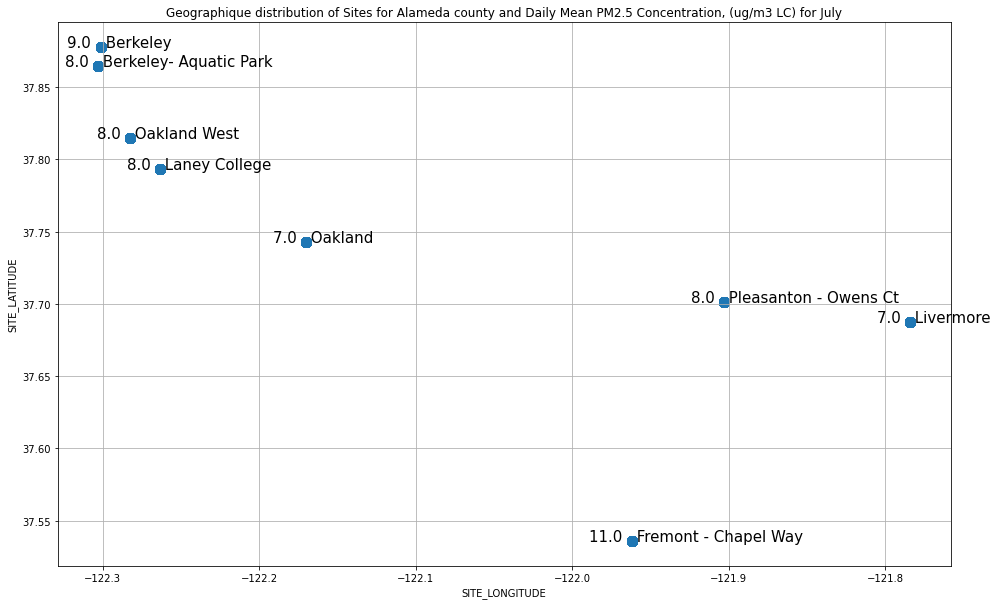

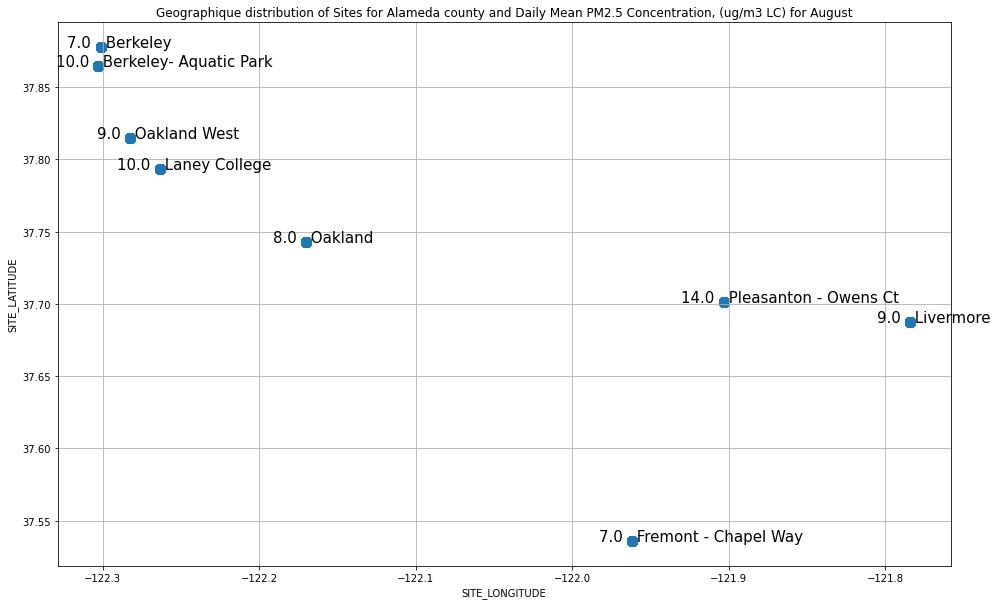

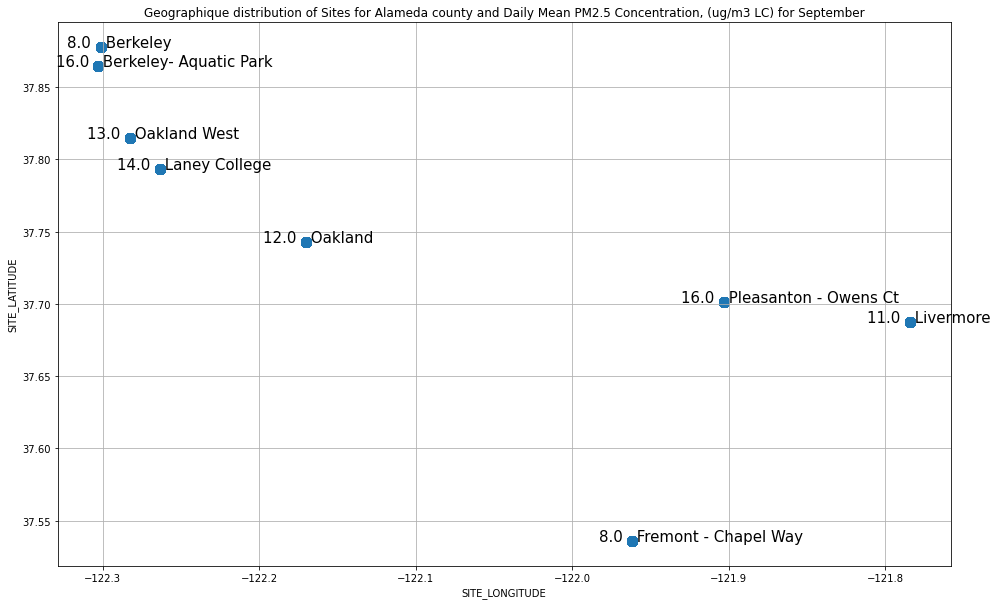

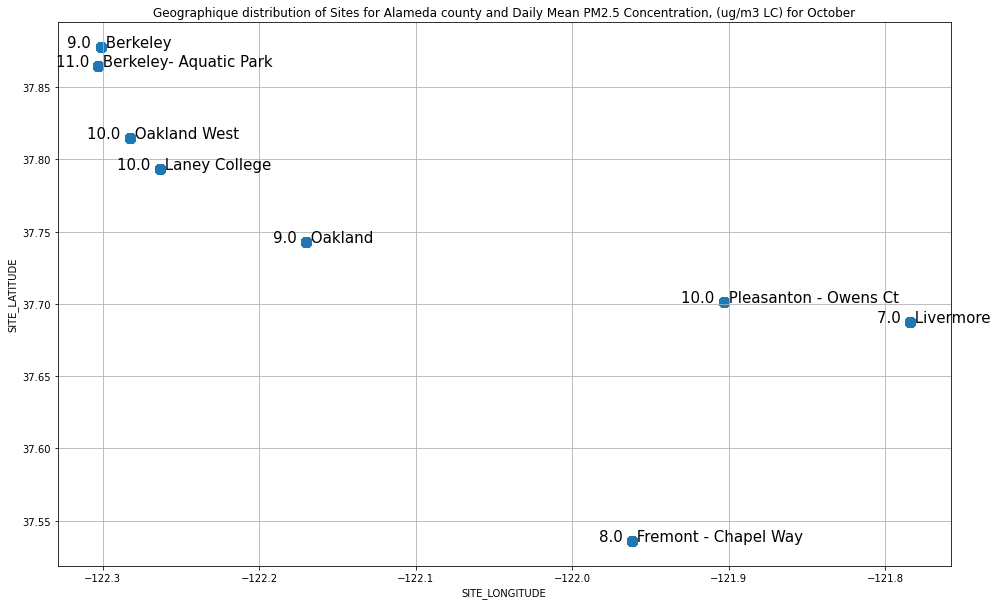

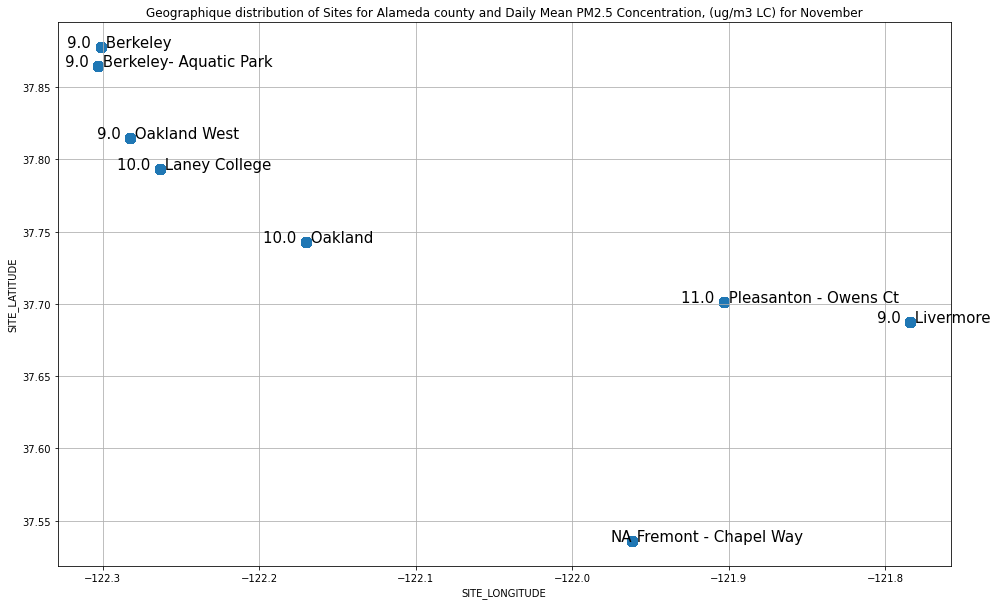

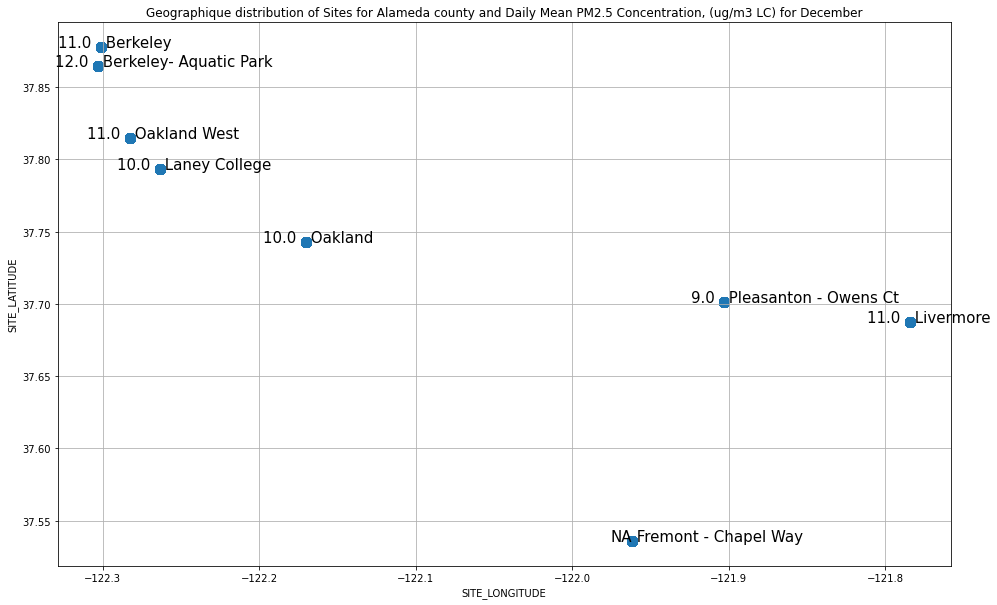

In [51]:
for j, m in ([(1,'January'), (2,'February'), (3,'March'), (4, 'April'), (5, "May"), (6, "June"), (7, "July"), 
              (8, "August"), (9, 'September'), (10,'October'), (11, 'November'), (12, "December") ]):
    
    y = Alameda_df_unique['SITE_LATITUDE'].unique()
    x = Alameda_df_unique['SITE_LONGITUDE'].unique()
    n = Alameda_df_unique['Site Name'].unique()

    plt.figure(figsize = (16, 10))
    plt.scatter(Alameda_df_unique['SITE_LONGITUDE'], Alameda_df_unique['SITE_LATITUDE'], s = 100)
    plt.ylabel('SITE_LATITUDE')
    plt.xlabel('SITE_LONGITUDE')
    plt.title("Geographique distribution of Sites for Alameda county and Daily Mean PM2.5 Concentration, (ug/m3 LC) for " + m)
    plt.grid()

    for i, txt in enumerate(n):
        plt.annotate(" " + txt, (x[i], y[i]), fontsize=15)
    

    month = []
    for i in n:  
        
        PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()
        
        if i == 'Fremont - Chapel Way' and (j == 11 or j == 12):
            site_pm = "NA"
        else:   
            site_pm = str(round(PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][j], 0)) + "  "
        month.append(site_pm)

    for k, txt in enumerate(month):
        plt.annotate(txt, (x[k], y[k]), fontsize=15, ha='right')
        
    plt.savefig("Air_Pollution_plots/Geographique_distribution/Geographique distribution of Sites for Alameda county and Daily Mean PM2.5 Concentration for " + m + ".pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [379]:
pratibha = pd.read_csv('California wildfire data collection 2008_2019 - California wildfire data collection 2008_2019.csv')
pratibha.head()

Incident Name Incident Number          County Fire Name Start Date  \
0         Bluff             NaN  San Bernardino       NaN  3/16/2008   
1       Colyear             NaN    Tehama-Glenn       NaN   5/6/2008   
2       Avocado             NaN    Fresno-Kings       NaN  5/20/2008   
3         Gatos             NaN    Fresno-Kings       NaN  5/22/2008   
4        Summit             NaN     Santa Clara       NaN  5/22/2008   

  Cont. Date Origin DPA Consumed Acres Total Vegetation Type          Cause  \
0  3/20/2008        NaN                  680    Brush, Grass       Campfire   
1   5/9/2008        NaN                1,331           Brush         Debris   
2  5/21/2008        NaN                1,100           Grass  Equipment Use   
3  5/22/2008        NaN                  331           Grass  Miscellaneous   
4  6/15/2008        NaN                4,270          Timber   Unidentified   

  Structures Destroyed  Structures Damaged  Fatalities Fire  Fatalities Civil  \
0                    0                   0                0               0.0   
1                    0                   0                0               0.0   
2                    0                   0                0               0.0   
3                    0                   0                0               0.0   
4                   91                   2                0               0.0   

   Injuries  
0       NaN  
1       NaN  
2       NaN  
3       NaN  
4       NaN

In [380]:
pratibha[pratibha.County == 'Alameda']

Incident Name Incident Number   County Fire Name Start Date Cont. Date  \
231           NaN      SCU-002461  Alameda    DIABLO  6/18/2010  6/19/2010   
698           NaN        SCU-4856  Alameda     GRANT   7/8/2018   7/9/2018   

    Origin DPA Consumed Acres Total Vegetation Type         Cause  \
231    CALFIRE                  475               G  Undetermined   
698   CAL FIRE                  480               G     FIREWORKS   

    Structures Destroyed  Structures Damaged  Fatalities Fire  \
231                    1                   0                0   
698                    1                   0                0   

     Fatalities Civil  Injuries  
231               0.0       NaN  
698               0.0       NaN

In [53]:
import folium

In [93]:
folium.TileLayer('stamenterrain').add_to(m)
m = folium.Map(location=[37.7, -122], zoom_start=10, tiles='Stamen Terrain')

y = Alameda_df_unique['SITE_LATITUDE'].unique()
x = Alameda_df_unique['SITE_LONGITUDE'].unique()
n = Alameda_df_unique['Site Name'].unique()


for i, txt in enumerate(n):

    marker2 = folium.Marker([y[i], x[i]])
    m.add_child(marker2)
    
    custom_icon1 = folium.DivIcon(
    html='<div style="font-size: 14px; color: red;">' + txt + '</div>',
    icon_size=(0, 0)  # Specify the size of the icon container
)
    marker1 = folium.Marker([y[i], x[i]], icon=custom_icon1)
    m.add_child(marker1)
    
    
    
m.save('Air_Pollution_plots/Geographique_distribution/Relief_maps/Alameda_relief_map.html')
m

In [375]:
import folium

for j, p in [(1,'January'), (2,'February'), (3,'March'), (4, 'April'), (5, "May"), (6, "June"), (7, "July"), 
              (8, "August"), (9, 'September'), (10,'October'), (11, 'November'), (12, "December") ]:

    # Create a base map with relief tiles
    m = folium.Map(location=[37.7, -122], zoom_start=10, tiles='Stamen Terrain')

    '''# Add a custom title marker to the map
    title_text = "Geographic distribution of Sites for Alameda county and Daily Mean PM2.5 Concentration, (ug/m3 LC) for " + p
    title_marker = folium.Marker(
        [37.8, -122],  # Coordinates for the title marker
        icon=folium.DivIcon(html=f'<div>{title_text}</div>'),
    )

    # Add the title marker to the map
    title_marker.add_to(m)'''

    y = Alameda_df_unique['SITE_LATITUDE'].unique()
    x = Alameda_df_unique['SITE_LONGITUDE'].unique()
    n = Alameda_df_unique['Site Name'].unique()

    for i, txt in enumerate(n):
        marker2 = folium.Marker([y[i], x[i]])
        m.add_child(marker2)

        custom_icon1 = folium.DivIcon(
            html='<div style="font-size: 14px; color: black;">' + txt + '</div>',
            icon_size=(0, 0)  # Specify the size of the icon container
        )
        marker1 = folium.Marker([y[i], x[i]], icon=custom_icon1)
        m.add_child(marker1)

    month = []
    for i in n:
        PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()
        if i == 'Fremont - Chapel Way' and (j == 11 or j == 12):
            site_pm = "NA"
        else:
            site_pm = str(round(PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][j], 0)) + "  "
        month.append(site_pm)

    for k, txt in enumerate(month):
        custom_icon2 = folium.DivIcon(
            html='<div style="font-size: 16px; color: red; text-align: left; margin-left: -30px; font-weight: bold;">' + txt  + '</div>',
            icon_size=(0, 0)  # Specify the size of the icon container
        )
        marker3 = folium.Marker([y[k], x[k]], icon=custom_icon2)
        m.add_child(marker3)

    display(m)
    m.save('Air_Pollution_plots/Geographique_distribution/Relief_maps/Alameda/Alameda_relief_map_for_' + p +'mean_month.html')

In [376]:
import folium

for j, p in [(1,'January'), (2,'February'), (3,'March'), (4, 'April'), (5, "May"), (6, "June"), (7, "July"), 
              (8, "August"), (9, 'September'), (10,'October'), (11, 'November'), (12, "December") ]:

    # Create a base map with relief tiles
    m = folium.Map(location=[37.7, -122], zoom_start=10, tiles='Stamen Terrain')

    '''# Add a custom title marker to the map
    title_text = "Geographic distribution of Sites for Alameda county and Daily Mean PM2.5 Concentration, (ug/m3 LC) for " + p
    title_marker = folium.Marker(
        [37.8, -122],  # Coordinates for the title marker
        icon=folium.DivIcon(html=f'<div>{title_text}</div>'),
    )

    # Add the title marker to the map
    title_marker.add_to(m)'''

    y = Alameda_df_unique['SITE_LATITUDE'].unique()
    x = Alameda_df_unique['SITE_LONGITUDE'].unique()
    n = Alameda_df_unique['Site Name'].unique()

    for i, txt in enumerate(n):
        marker2 = folium.Marker([y[i], x[i]])
        m.add_child(marker2)

        custom_icon1 = folium.DivIcon(
            html='<div style="font-size: 14px; color: black;">' + txt + '</div>',
            icon_size=(0, 0)  # Specify the size of the icon container
        )
        marker1 = folium.Marker([y[i], x[i]], icon=custom_icon1)
        m.add_child(marker1)

    month = []
    for i in n:
        PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).max()
        if i == 'Fremont - Chapel Way' and (j == 11 or j == 12):
            site_pm = "NA"
        else:
            site_pm = str(round(PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][j], 0)) + "  "
        month.append(site_pm)

    for k, txt in enumerate(month):
        custom_icon2 = folium.DivIcon(
            html='<div style="font-size: 16px; color: red; text-align: left; margin-left: -30px; font-weight: bold;">' + txt  + '</div>',
            icon_size=(0, 0)  # Specify the size of the icon container
        )
        marker3 = folium.Marker([y[k], x[k]], icon=custom_icon2)
        m.add_child(marker3)

    display(m)
    m.save('Air_Pollution_plots/Geographique_distribution/Relief_maps/Alameda/Alameda_relief_map_for_' + p +'_max_month.html')

In [169]:
import folium
from folium.plugins import TimestampedGeoJson
import json
import pandas as pd

# Create an empty list to store map objects and features
maps = []
features = []

for j, p in [(1, 'January'), (2, 'February'), (3, 'March'), (4, 'April'), (5, 'May'), (6, 'June'), (7, 'July'),
            (8, 'August'), (9, 'September'), (10, 'October'), (11, 'November'), (12, 'December')]:

    # Create a base map with relief tiles
    m = folium.Map(location=[37.7, -122], zoom_start=10, tiles='Stamen Terrain')

    y = Alameda_df_unique['SITE_LATITUDE'].unique()
    x = Alameda_df_unique['SITE_LONGITUDE'].unique()
    n = Alameda_df_unique['Site Name'].unique()

    for i, txt in enumerate(n):
        marker2 = folium.Marker([y[i], x[i]])
        m.add_child(marker2)

        custom_icon1 = folium.DivIcon(
            html='<div style="font-size: 14px; color: black;">' + txt + '</div>',
            icon_size=(0, 0)  # Specify the size of the icon container
        )
        marker1 = folium.Marker([y[i], x[i]], icon=custom_icon1)
        m.add_child(marker1)

    month = []
    for i in n:
        PM25_months = Alameda_df_unique[Alameda_df_unique['Site Name'] == i][
            ['Month', 'Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).mean()
        if i == 'Fremont - Chapel Way' and (j == 11 or j == 12):
            site_pm = "NA"
        else:
            site_pm = str(round(PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'][j], 0)) + "  "
        month.append(site_pm)

    for k, txt in enumerate(month):
        custom_icon2 = folium.DivIcon(
            html='<div style="font-size: 16px; color: red; text-align: left; margin-left: -30px; font-weight: bold;">' + txt + '</div>',
            icon_size=(0, 0)  # Specify the size of the icon container
        )
        marker3 = folium.Marker([y[k], x[k]], icon=custom_icon2)
        m.add_child(marker3)

    maps.append(m)

    # Create a custom HTML for the popup content
    popup_html = f"""
    <h3>Geographic distribution of Sites for Alameda county</h3>
    <p>Daily Mean PM2.5 Concentration, (ug/m3 LC) for {p}</p>
    """

    # Create a feature for this map
    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [37.7, -122],  # You can set a fixed coordinate here
        },
        'properties': {
            'time': f'2023-09-16T{12 + j:02d}:00',  # Use your desired timestamp format
            'popup': folium.Popup(popup_html, max_width=650).add_to(m).render()  # Add the custom HTML to the popup
        }
    }
    features.append(feature)

# Create an empty map for the animation
animated_map = folium.Map(location=[37.7, -122], zoom_start=10)

# Add the TimestampedGeoJson plugin with features
TimestampedGeoJson({'type': 'FeatureCollection', 'features': features}).add_to(animated_map)

# Save the animated map
animated_map.save('Air_Pollution_plots/Geographique_distribution/Relief_maps/Air_Pollution_Animation.html')
animated_map


In [106]:
Alameda_PM25_months = Alameda_df_unique[['Month','Daily Mean PM2.5 Concentration, ug/m3 LC']].groupby(pd.Grouper(key='Month')).max()
Alameda_PM25_months

Daily Mean PM2.5 Concentration, ug/m3 LC
Month                                          
1                                          42.9
2                                          29.0
3                                          20.2
4                                          22.5
5                                          21.5
6                                          23.0
7                                          41.1
8                                          99.9
9                                         167.7
10                                        103.9
11                                         32.5
12                                         49.3

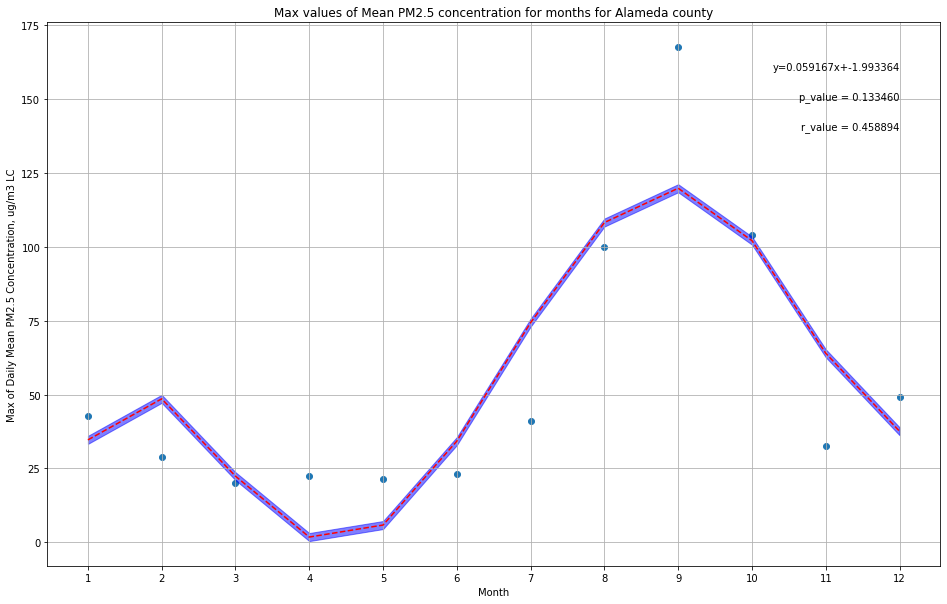

In [117]:
from sympy import S, symbols, printing
import scipy

plt.figure(figsize = (16, 10))
plt.scatter(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])
plt.xticks(Alameda_PM25_months.index)
plt.xlabel('Month')
plt.ylabel('Max of Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Max values of Mean PM2.5 concentration for months for Alameda county")
plt.grid()

z = np.polyfit(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], 5)
p = np.poly1d(z)
plt.plot(Alameda_PM25_months.index,p(Alameda_PM25_months.index),"r--")

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'])

#Define the confidence interval
ci = 1.96 * np.std(p(Alameda_PM25_months.index)) / np.mean(p(Alameda_PM25_months.index))
plt.fill_between(Alameda_PM25_months.index, (p(Alameda_PM25_months.index)-ci), (p(Alameda_PM25_months.index)+ci), color='blue', alpha=0.5)

plt.text(12,160,"y=%.6fx+%.6f"%(z[0],z[1]), ha='right') 
plt.text(12,150,"p_value = %.6f"%p_value, ha='right') 
plt.text(12,140,"r_value = %.6f"%r_value, ha = "right")
plt.savefig("Max values of Mean PM2.5 concentration for months for Alameda county.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [108]:
for i in [1,2,3,4,5]:
    
    z = np.polyfit(Alameda_PM25_months.index, Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], i)
    p = np.poly1d(z)
    # Calculate R-squared
    from sklearn.metrics import r2_score
    r_squared = r2_score(Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], p(Alameda_PM25_months.index))

    # Calculate Mean Squared Error (MSE)
    from sklearn.metrics import mean_squared_error
    mse = mean_squared_error(Alameda_PM25_months['Daily Mean PM2.5 Concentration, ug/m3 LC'], p(Alameda_PM25_months.index))

    print(i, r_squared, mse)

1 0.21058396293440362 1517.8423941336441
2 0.22909286937440887 1482.2545652264405
3 0.6187644437180588 733.0171447071449
4 0.6390121910892015 694.0859754597249
5 0.7463108953489028 487.7783828671389


In [58]:
Alameda_df_unique[Alameda_df_unique['Date'] == Alameda_df_unique['Date'][0]]

Date             Site Name  POC  \
0 2010-01-01              Berkeley  1.0   
1 2010-01-01  Fremont - Chapel Way  3.0   
2 2010-01-01             Livermore  1.0   
3 2010-01-01               Oakland  3.0   
4 2010-01-01          Oakland West  1.0   

   Daily Mean PM2.5 Concentration, ug/m3 LC  DAILY_AQI_VALUE  \
0                                      11.8             49.0   
1                                      14.5             56.0   
2                                      18.5             64.0   
3                                      12.2             51.0   
4                                      14.7             56.0   

   PERCENT_COMPLETE  SITE_LATITUDE  SITE_LONGITUDE  \
0             100.0      37.877794     -122.301290   
1             100.0      37.535833     -121.961823   
2             100.0      37.687526     -121.784217   
3             100.0      37.743065     -122.169935   
4             100.0      37.814781     -122.282347   

   Daily Max 8-hour CO Concentration  Year Year_Month  Month  
0                                NaN  2010    2010-01      1  
1                                NaN  2010    2010-01      1  
2                                NaN  2010    2010-01      1  
3                                NaN  2010    2010-01      1  
4                                NaN  2010    2010-01      1

In [59]:
Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'].describe()

count    16387.000000
mean         8.833890
std          7.528514
min         -1.300000
25%          5.000000
50%          7.400000
75%         10.900000
max        167.700000
Name: Daily Mean PM2.5 Concentration, ug/m3 LC, dtype: float64

In [60]:
Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'][Alameda_df_unique['Site Name'] == "Livermore"].describe()

count    3573.000000
mean        7.898279
std         7.030268
min        -0.900000
25%         4.200000
50%         6.400000
75%         9.400000
max       122.000000
Name: Daily Mean PM2.5 Concentration, ug/m3 LC, dtype: float64

In [61]:
Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'][Alameda_df_unique['Site Name'] == "Berkeley"].describe()

count    364.000000
mean       8.787637
std        4.952656
min        1.300000
25%        5.300000
50%        7.750000
75%       11.400000
max       30.700000
Name: Daily Mean PM2.5 Concentration, ug/m3 LC, dtype: float64

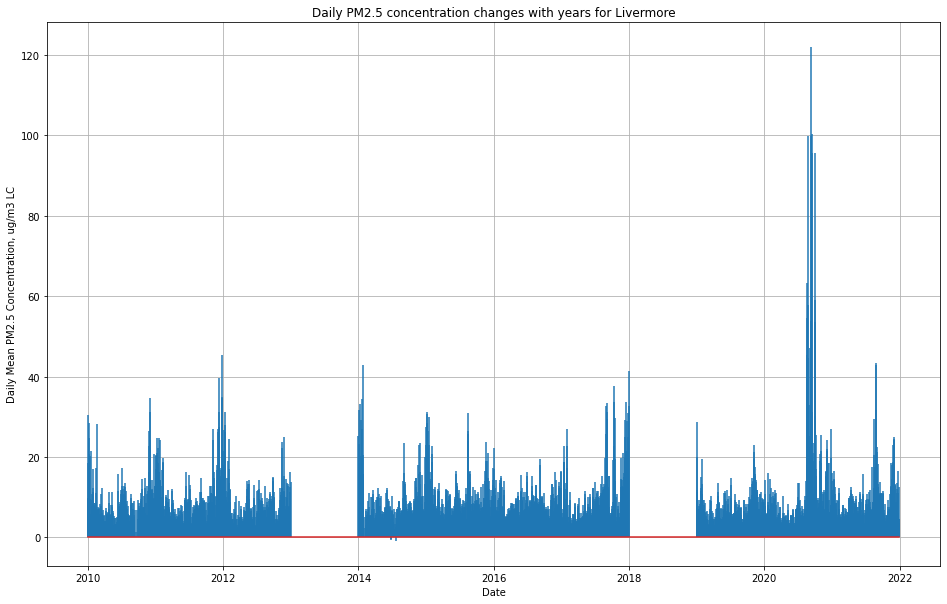

In [62]:
plt.figure(figsize = (16, 10))
plt.stem(Alameda_df_unique['Date'][Alameda_df_unique['Site Name'] == "Livermore"], 
         Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'][Alameda_df_unique['Site Name'] == "Livermore"],
         markerfmt=' ')
plt.xlabel('Date')
plt.ylabel('Daily Mean PM2.5 Concentration, ug/m3 LC')
plt.title("Daily PM2.5 concentration changes with years for Livermore")
plt.grid()

In [ ]:
livermorePM25 = Alameda_df_unique[['Date','Daily Mean PM2.5 Concentration, ug/m3 LC']][Alameda_df_unique['Site Name'] == "Livermore"]

In [ ]:
livermorePM25

In [ ]:
livermorePM25['Date'].duplicated().sum()

In [ ]:
livermorePM25_unique = livermorePM25.groupby(['Date']).mean()
livermorePM25_unique

In [ ]:
livermorePM25_unique.dropna(inplace = True)

In [ ]:
livermorePM25_unique.isna().sum()

In [ ]:
np.all(np.isfinite(livermorePM25_unique))

In [ ]:
livermorePM25_unique.loc['2010-01-01':'2011-12-31'].shape

Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.


In [ ]:
%matplotlib inline
import statsmodels.api as sm

plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(livermorePM25_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'], freq=360).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(livermorePM25_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'])[1])

p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [ ]:
AlamedaPM25 = Alameda_df_unique[['Date','Daily Mean PM2.5 Concentration, ug/m3 LC']]

In [ ]:
AlamedaPM25

In [ ]:
AlamedaPM25.isna().sum()

In [ ]:
AlamedaPM25.dropna(inplace = True)

In [ ]:
%matplotlib inline
import statsmodels.api as sm

plt.figure(figsize(16,10))
sm.tsa.seasonal_decompose(AlamedaPM25['Daily Mean PM2.5 Concentration, ug/m3 LC'], freq=360).plot()
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(AlamedaPM25['Daily Mean PM2.5 Concentration, ug/m3 LC'])[1])

In [177]:
Alameda_df_unique

Date              Site Name  POC  \
0     2010-01-01               Berkeley  1.0   
1     2010-01-01   Fremont - Chapel Way  3.0   
2     2010-01-01              Livermore  1.0   
3     2010-01-01                Oakland  3.0   
4     2010-01-01           Oakland West  1.0   
...          ...                    ...  ...   
17111 2021-12-31          Laney College  3.0   
17112 2021-12-31              Livermore  3.0   
17113 2021-12-31                Oakland  3.0   
17114 2021-12-31           Oakland West  3.0   
17115 2021-12-31  Pleasanton - Owens Ct  3.0   

       Daily Mean PM2.5 Concentration, ug/m3 LC  DAILY_AQI_VALUE  \
0                                          11.8             49.0   
1                                          14.5             56.0   
2                                          18.5             64.0   
3                                          12.2             51.0   
4                                          14.7             56.0   
...                                         ...              ...   
17111                                       3.0             13.0   
17112                                      12.5             52.0   
17113                                       8.3             35.0   
17114                                       4.7             20.0   
17115                                       5.2             22.0   

       PERCENT_COMPLETE  SITE_LATITUDE  SITE_LONGITUDE  \
0                 100.0      37.877794     -122.301290   
1                 100.0      37.535833     -121.961823   
2                 100.0      37.687526     -121.784217   
3                 100.0      37.743065     -122.169935   
4                 100.0      37.814781     -122.282347   
...                 ...            ...             ...   
17111             100.0      37.793624     -122.263376   
17112             100.0      37.687526     -121.784217   
17113             100.0      37.743065     -122.169935   
17114             100.0      37.814781     -122.282347   
17115             100.0      37.701222     -121.903019   

       Daily Max 8-hour CO Concentration  Year Year_Month  Month  
0                                    NaN  2010    2010-01      1  
1                                    NaN  2010    2010-01      1  
2                                    NaN  2010    2010-01      1  
3                                    NaN  2010    2010-01      1  
4                                    NaN  2010    2010-01      1  
...                                  ...   ...        ...    ...  
17111                                NaN  2021    2021-12     12  
17112                                NaN  2021    2021-12     12  
17113                                NaN  2021    2021-12     12  
17114                                NaN  2021    2021-12     12  
17115                                NaN  2021    2021-12     12  

[17116 rows x 12 columns]

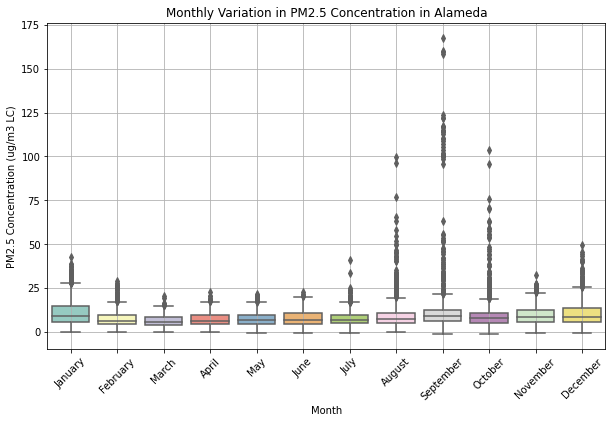

In [352]:
# Boxplot for PM2.5 Concentration per month
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', data=Alameda_df_unique, palette='Set3')
plt.title('Monthly Variation in PM2.5 Concentration in Alameda')
plt.xlabel('Month')
plt.ylabel('PM2.5 Concentration (ug/m3 LC)')
plt.grid()

plt.xticks(np.arange(0, 12), calendar.month_name[1:], rotation=45)

plt.savefig("Presentation/Boxplot - Monthly Variation in PM2.5 Concentration for Alameda county.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a list of unique counties
counties = Alameda_df_unique['County'].unique()

# Set the figure size
plt.figure(figsize=(10, 6))

# Iterate through each county and create a boxplot
for county in counties:
    county_data = Alameda_df_unique[Alameda_df_unique['County'] == county]
    
    sns.boxplot(x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', data=county_data, palette='Set3')
    
    plt.title(f'Monthly Variation in PM2.5 Concentration in {county}')
    plt.xlabel('Month')
    plt.ylabel('PM2.5 Concentration (ug/m3 LC)')
    plt.grid()
    plt.xticks(np.arange(0, 12), calendar.month_name[1:], rotation=45)
    
    # Save each plot with a unique filename
    plt.savefig(f"Presentation/Boxplot - Monthly Variation in PM2.5 Concentration for {county}.pdf", format="pdf", bbox_inches="tight")
    
    plt.show()


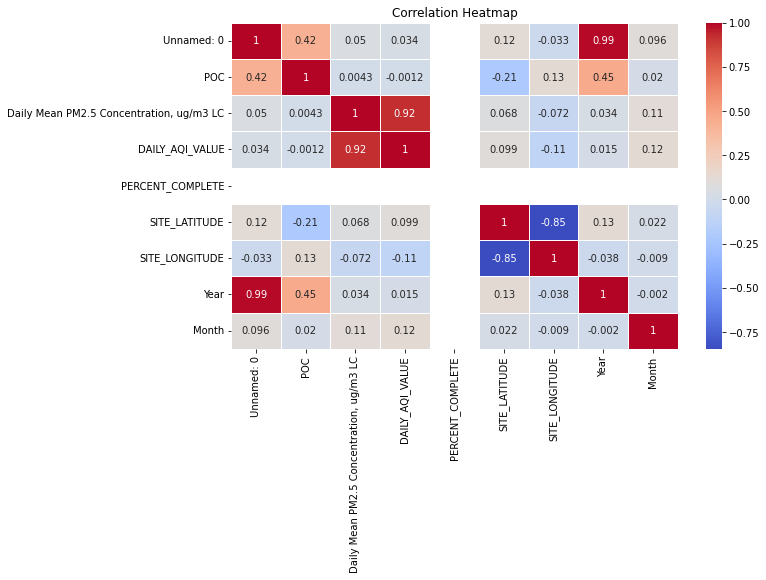

In [312]:
# Correlation heatmap
correlation_matrix = Alameda_df_unique.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')

plt.savefig("Presentation/Correlation Heatmap.pdf", format="pdf", bbox_inches="tight")
plt.show()

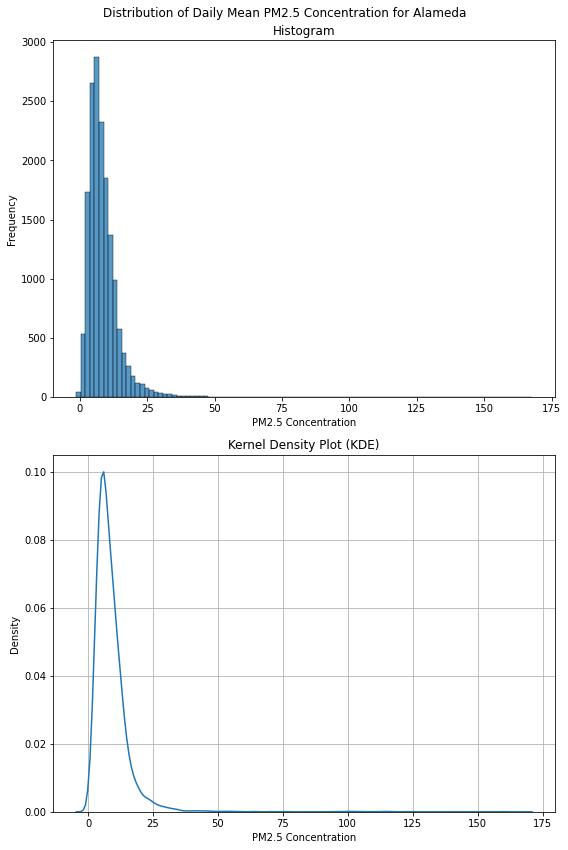

In [313]:
# Create subplots with histograms and KDE plots
fig, axes = plt.subplots(2, 1, figsize=(8, 12))

# Histogram
sns.histplot(Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'], bins=100, kde=False, ax=axes[0])
axes[0].set_title('Histogram')
axes[0].set_xlabel('PM2.5 Concentration')
axes[0].set_ylabel('Frequency')

# KDE Plot
sns.kdeplot(Alameda_df_unique['Daily Mean PM2.5 Concentration, ug/m3 LC'], ax=axes[1])
axes[1].set_title('Kernel Density Plot (KDE)')
axes[1].set_xlabel('PM2.5 Concentration')
axes[1].set_ylabel('Density')

# Add a title for the entire plot
plt.suptitle('Distribution of Daily Mean PM2.5 Concentration for Alameda')

# Show the plots
plt.tight_layout()
plt.grid()

plt.savefig("Presentation/Histogram - Distribution of Daily Mean PM2.5 Concentration for Alameda.pdf", format="pdf", bbox_inches="tight")
plt.show()

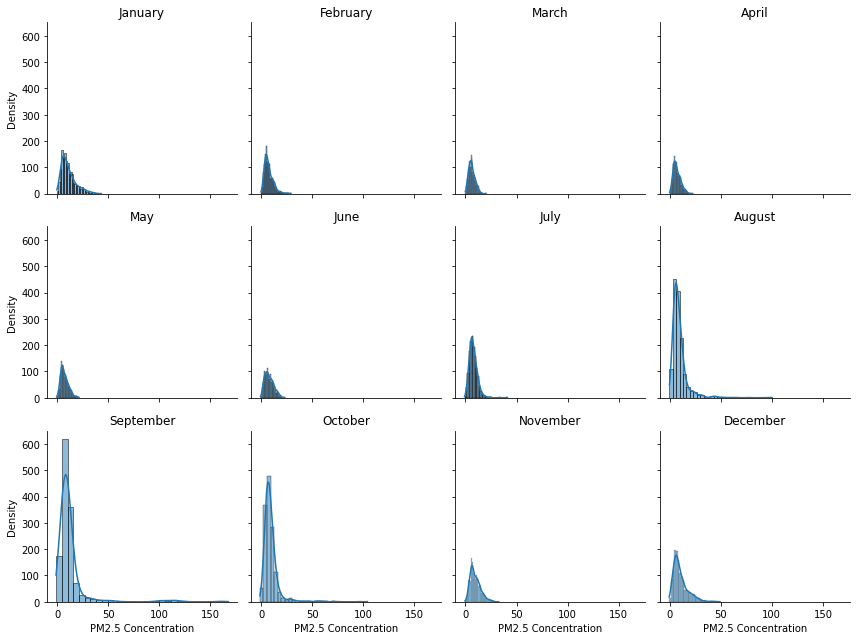

In [186]:
# Create subplots for each month
g = sns.FacetGrid(Alameda_df_unique, col="Month", col_wrap=4, height=3, margin_titles=True)
g.map_dataframe(sns.histplot, x="Daily Mean PM2.5 Concentration, ug/m3 LC", bins=30, kde=True)
g.set_axis_labels("PM2.5 Concentration", "Density")

# Add titles for each subplot
months = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June', 7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
for ax, month in zip(g.axes.flat, range(1, 13)):
    ax.set_title(months[month])

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

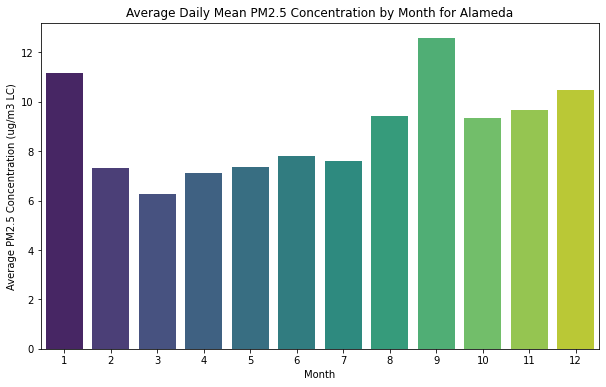

In [314]:
# Calculate the average PM2.5 concentration for each month
average_pm25_by_month = Alameda_df_unique.groupby('Month')['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data=average_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', palette='viridis')

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Month for Alameda')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')

plt.savefig("Presentation/Barplot - Average Daily Mean PM2.5 Concentration by Month for Alameda.pdf", format="pdf", bbox_inches="tight")
plt.show()

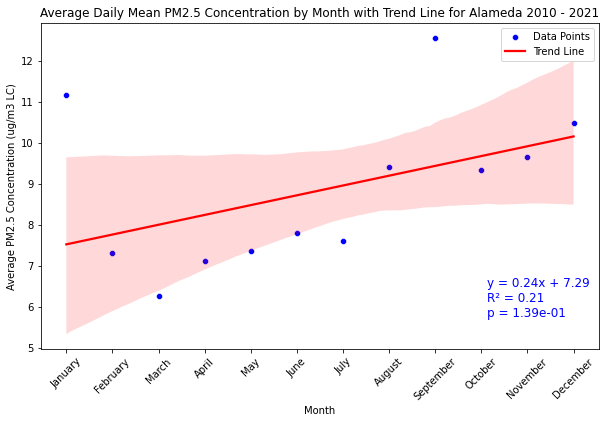

In [315]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate the average PM2.5 concentration for each month
average_pm25_by_month = Alameda_df_unique.groupby('Month')['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean().reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=average_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b', label='Data Points')

# Fit a linear regression line
sns.regplot(data=average_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', scatter=False, color='r', label='Trend Line')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(average_pm25_by_month['Month'], average_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'])

# Create the regression equation string
regression_eq = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}\np = {p_value:.2e}'

# Annotate the plot with the regression equation and statistical values
plt.annotate(regression_eq, xy=(0.8, 0.1), xycoords='axes fraction', fontsize=12, color='b')

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Month with Trend Line for Alameda 2010 - 2021')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')
plt.legend()
plt.xticks(np.arange(1, 13), calendar.month_name[1:], rotation=45)

plt.savefig("Presentation/Average Daily Mean PM2.5 Concentration by Month with Trend Line for Alameda.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

<ipython-input-196-23bf7f4d5523>:27: RuntimeWarning: invalid value encountered in sqrt
  std_dev = np.sqrt(variance)


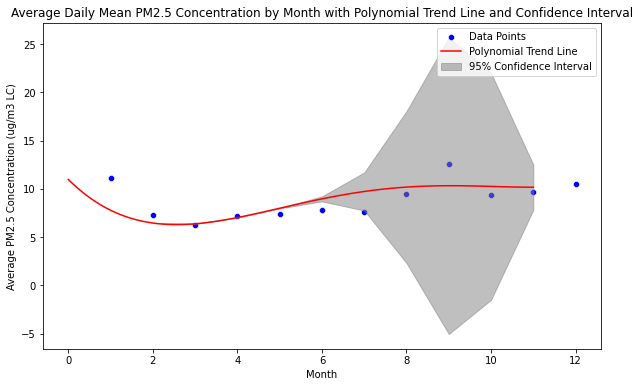

In [196]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats


# Calculate the average PM2.5 concentration for each month
average_pm25_by_month = Alameda_df_unique.groupby('Month')['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean().reset_index()

# Define the degree of the polynomial (you can adjust this)
degree = 4

# Fit the polynomial curve to the data
coeff = np.polyfit(average_pm25_by_month.index, average_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'], degree)

# Generate points for the polynomial curve
x_curve = np.linspace(0, 11, 100)  # Adjust the range based on your data
y_curve = np.polyval(coeff, x_curve)

# Calculate the confidence interval for the data points
y_pred = np.polyval(coeff, average_pm25_by_month.index)
residuals = average_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'] - y_pred
mse = np.sum(residuals**2) / (len(average_pm25_by_month) - (degree + 1))
variance = mse * np.diag(np.linalg.inv(np.dot(np.transpose(np.vander(average_pm25_by_month.index)), np.vander(average_pm25_by_month.index))))
std_dev = np.sqrt(variance)

# Define the confidence level (e.g., 95%)
confidence_level = 0.95
z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)
margin_of_error = z_score * std_dev

# Calculate upper and lower confidence intervals for the data points
upper_ci = y_pred + margin_of_error
lower_ci = y_pred - margin_of_error

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=average_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b', label='Data Points')

# Plot the polynomial trend line
plt.plot(x_curve, y_curve, color='r', label='Polynomial Trend Line')

# Plot the confidence intervals for the data points
plt.fill_between(average_pm25_by_month.index, upper_ci, lower_ci, color='gray', alpha=0.5, label=f'{int(confidence_level*100)}% Confidence Interval')

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Month with Polynomial Trend Line and Confidence Interval')
plt.xlabel('Month')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')
plt.legend()

# Show the plot
plt.show()


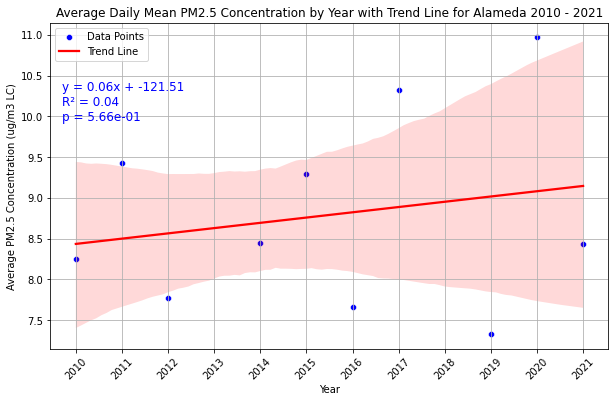

In [316]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate the average PM2.5 concentration for each year
average_pm25_by_year = Alameda_df_unique.groupby('Year')['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean().reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b', label='Data Points')

# Fit a linear regression line
sns.regplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration, ug/m3 LC', scatter=False, color='r', label='Trend Line')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(average_pm25_by_year['Year'], average_pm25_by_year['Daily Mean PM2.5 Concentration, ug/m3 LC'])

# Create the regression equation string
regression_eq = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}\np = {p_value:.2e}'

# Annotate the plot with the regression equation and statistical values
plt.annotate(regression_eq, xy=(0.02, 0.7), xycoords='axes fraction', fontsize=12, color='b')

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Year with Trend Line for Alameda 2010 - 2021')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')
plt.legend()
plt.grid()

# Set x ticks for every year
plt.xticks(np.arange(min(average_pm25_by_year['Year']), max(average_pm25_by_year['Year'])+1, 1), rotation=45)

plt.savefig("Presentation/Average Daily Mean PM2.5 Concentration by Year with Trend Line for Alameda.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

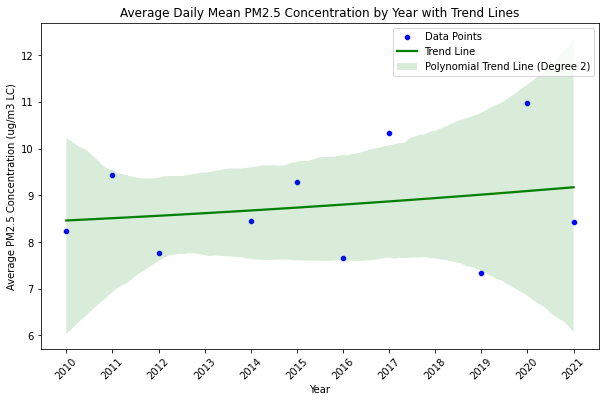

In [224]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Calculate the average PM2.5 concentration for each year
average_pm25_by_year = Alameda_df_unique.groupby('Year')['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean().reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b', label='Data Points')

# Fit a linear regression line
#sns.regplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration, ug/m3 LC', scatter=False, color='r', label='Trend Line')

# Fit a polynomial regression line (degree=2)
sns.regplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration, ug/m3 LC', order=2, scatter=False, color='g')

# Add a custom legend entry for the polynomial trend line
plt.legend(labels=['Data Points', 'Trend Line', 'Polynomial Trend Line (Degree 2)'])

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Year with Trend Lines')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')

# Set x ticks for every year
plt.xticks(np.arange(min(average_pm25_by_year['Year']), max(average_pm25_by_year['Year']) + 1, 1), rotation=45)

# Show the plot
plt.show()

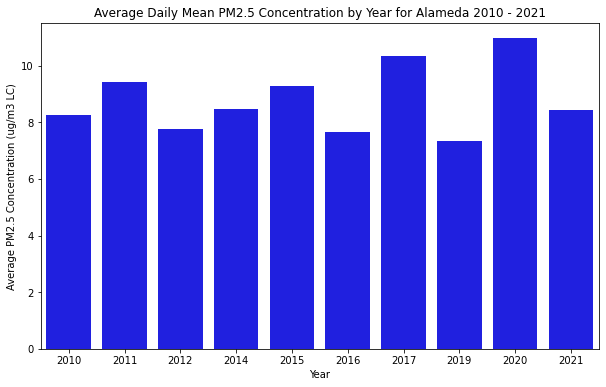

In [317]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the average PM2.5 concentration for each year
average_pm25_by_year = Alameda_df_unique.groupby('Year')['Daily Mean PM2.5 Concentration, ug/m3 LC'].mean().reset_index()

# Create a barplot
plt.figure(figsize=(10, 6))
sns.barplot(data=average_pm25_by_year, x='Year', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b')

# Customize the plot
plt.title('Average Daily Mean PM2.5 Concentration by Year for Alameda 2010 - 2021')
plt.xlabel('Year')
plt.ylabel('Average PM2.5 Concentration (ug/m3 LC)')

# Set x ticks for every year
#plt.xticks(rotation=45)

plt.savefig("Presentation/Barplot - Average Daily Mean PM2.5 Concentration by Year with Trend Line for Alameda.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

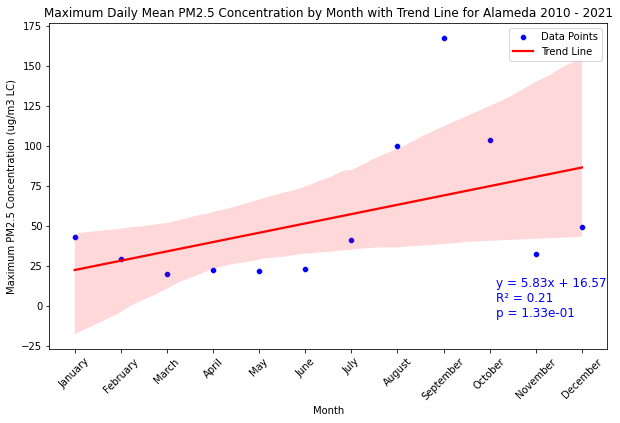

In [318]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress

# Calculate the maximum PM2.5 concentration for each month
max_pm25_by_month = Alameda_df_unique.groupby('Month')['Daily Mean PM2.5 Concentration, ug/m3 LC'].max().reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=max_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b', label='Data Points')

# Fit a linear regression line
sns.regplot(data=max_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', scatter=False, color='r', label='Trend Line')

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(max_pm25_by_month['Month'], max_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'])

# Create the regression equation string
regression_eq = f'y = {slope:.2f}x + {intercept:.2f}\nR² = {r_value**2:.2f}\np = {p_value:.2e}'

# Annotate the plot with the regression equation and statistical values
plt.annotate(regression_eq, xy=(0.8, 0.1), xycoords='axes fraction', fontsize=12, color='b')

# Customize the plot
plt.title('Maximum Daily Mean PM2.5 Concentration by Month with Trend Line for Alameda 2010 - 2021')
plt.xlabel('Month')
plt.ylabel('Maximum PM2.5 Concentration (ug/m3 LC)')
plt.legend()
plt.xticks(np.arange(1, 13), calendar.month_name[1:], rotation=45)

plt.savefig("Presentation/Maximum Daily Mean PM2.5 Concentration by Month with Trend Line for Alameda.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()

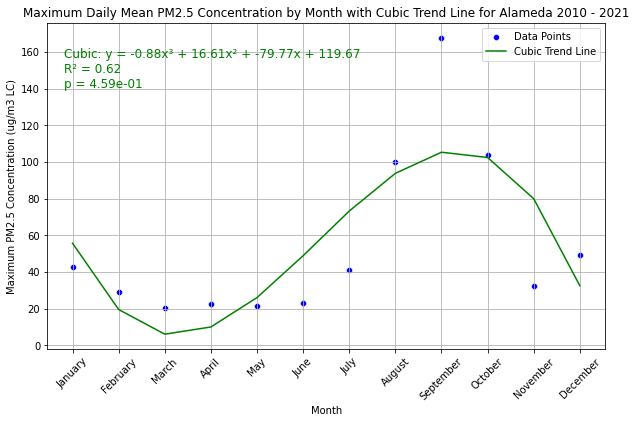

In [353]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from sklearn.metrics import r2_score

# Calculate the maximum PM2.5 concentration for each month
max_pm25_by_month = Alameda_df_unique.groupby('Month')['Daily Mean PM2.5 Concentration, ug/m3 LC'].max().reset_index()

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=max_pm25_by_month, x='Month', y='Daily Mean PM2.5 Concentration, ug/m3 LC', color='b', label='Data Points')

# Fit a polynomial regression line (degree=3)
coefficients = np.polyfit(max_pm25_by_month['Month'], max_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'], 3)
polynomial = np.poly1d(coefficients)
x_values = max_pm25_by_month['Month']
y_values = polynomial(x_values)
sns.lineplot(x=x_values, y=y_values, color='g', label='Cubic Trend Line')

# Calculate R²
y_pred = polynomial(max_pm25_by_month['Month'])
r_squared = r2_score(max_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'], y_pred)

# Perform linear regression
slope, intercept, p_value, _, _ = linregress(max_pm25_by_month['Month'], max_pm25_by_month['Daily Mean PM2.5 Concentration, ug/m3 LC'])

# Create the regression equation string
regression_eq = f'Cubic: y = {coefficients[0]:.2f}x³ + {coefficients[1]:.2f}x² + {coefficients[2]:.2f}x + {coefficients[3]:.2f}\nR² = {r_squared:.2f}\np = {p_value:.2e}'

# Annotate the plot with the regression equation and statistical values
plt.annotate(regression_eq, xy=(0.03, 0.8), xycoords='axes fraction', fontsize=12, color='g')

# Customize the plot
plt.title('Maximum Daily Mean PM2.5 Concentration by Month with Cubic Trend Line for Alameda 2010 - 2021')
plt.xlabel('Month')
plt.ylabel('Maximum PM2.5 Concentration (ug/m3 LC)')
plt.legend()
plt.xticks(np.arange(1, 13), calendar.month_name[1:], rotation=45)
plt.grid()

plt.savefig("Presentation/Maximum Daily Mean PM2.5 Concentration by Month with Cubic Trend Line for Alameda.pdf", format="pdf", bbox_inches="tight")

# Show the plot
plt.show()


In [264]:
Alameda_df_unique

Unnamed: 0        Date              Site Name  POC  \
0               0  2010-01-01               Berkeley  1.0   
1               1  2010-01-01   Fremont - Chapel Way  3.0   
2               2  2010-01-01              Livermore  1.0   
3               3  2010-01-01                Oakland  3.0   
4               4  2010-01-01           Oakland West  1.0   
...           ...         ...                    ...  ...   
17111       17111  2021-12-31          Laney College  3.0   
17112       17112  2021-12-31              Livermore  3.0   
17113       17113  2021-12-31                Oakland  3.0   
17114       17114  2021-12-31           Oakland West  3.0   
17115       17115  2021-12-31  Pleasanton - Owens Ct  3.0   

       Daily Mean PM2.5 Concentration, ug/m3 LC  DAILY_AQI_VALUE  \
0                                          11.8             49.0   
1                                          14.5             56.0   
2                                          18.5             64.0   
3                                          12.2             51.0   
4                                          14.7             56.0   
...                                         ...              ...   
17111                                       3.0             13.0   
17112                                      12.5             52.0   
17113                                       8.3             35.0   
17114                                       4.7             20.0   
17115                                       5.2             22.0   

       PERCENT_COMPLETE  SITE_LATITUDE  SITE_LONGITUDE  \
0                 100.0      37.877794     -122.301290   
1                 100.0      37.535833     -121.961823   
2                 100.0      37.687526     -121.784217   
3                 100.0      37.743065     -122.169935   
4                 100.0      37.814781     -122.282347   
...                 ...            ...             ...   
17111             100.0      37.793624     -122.263376   
17112             100.0      37.687526     -121.784217   
17113             100.0      37.743065     -122.169935   
17114             100.0      37.814781     -122.282347   
17115             100.0      37.701222     -121.903019   

       Daily Max 8-hour CO Concentration  Year Year_Month  Month  
0                                    NaN  2010    2010-01      1  
1                                    NaN  2010    2010-01      1  
2                                    NaN  2010    2010-01      1  
3                                    NaN  2010    2010-01      1  
4                                    NaN  2010    2010-01      1  
...                                  ...   ...        ...    ...  
17111                                NaN  2021    2021-12     12  
17112                                NaN  2021    2021-12     12  
17113                                NaN  2021    2021-12     12  
17114                                NaN  2021    2021-12     12  
17115                                NaN  2021    2021-12     12  

[17116 rows x 13 columns]

In [275]:
Alameda_df_unique.isna().sum()

Unnamed: 0                                  0
Date                                        0
Site Name                                   0
POC                                         0
Daily Mean PM2.5 Concentration, ug/m3 LC    0
DAILY_AQI_VALUE                             0
PERCENT_COMPLETE                            0
SITE_LATITUDE                               0
SITE_LONGITUDE                              0
Year                                        0
Year_Month                                  0
Month                                       0
dtype: int64

In [272]:
Alameda_df_unique = Alameda_df_unique.drop(['Daily Max 8-hour CO Concentration'], axis = 1)

In [274]:
Alameda_df_unique = Alameda_df_unique.dropna(subset=['Daily Mean PM2.5 Concentration, ug/m3 LC'])

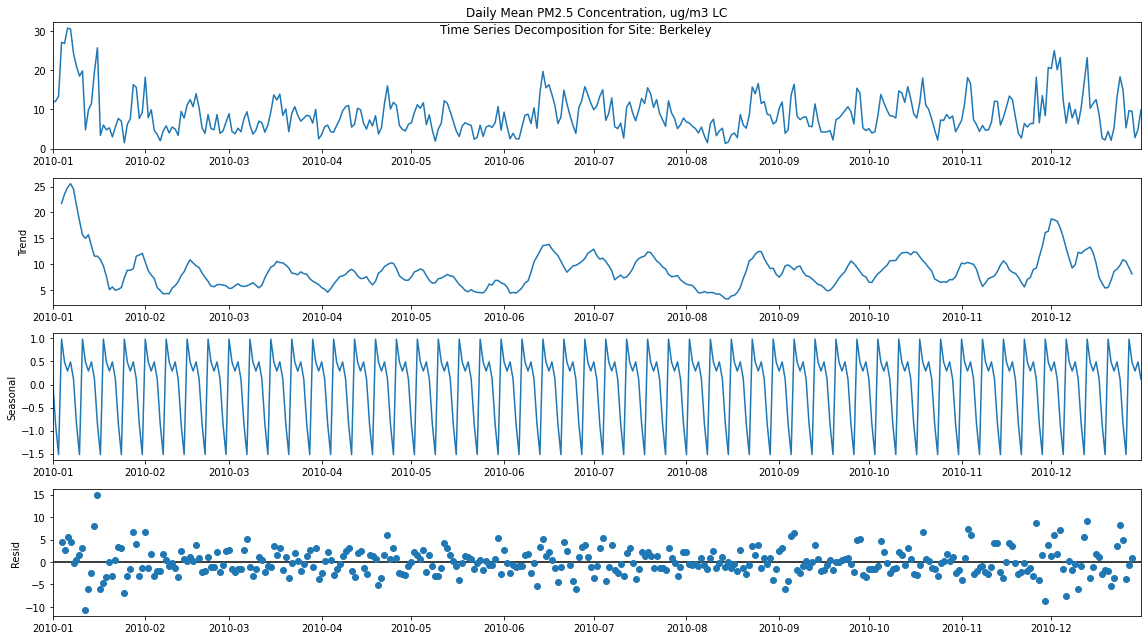

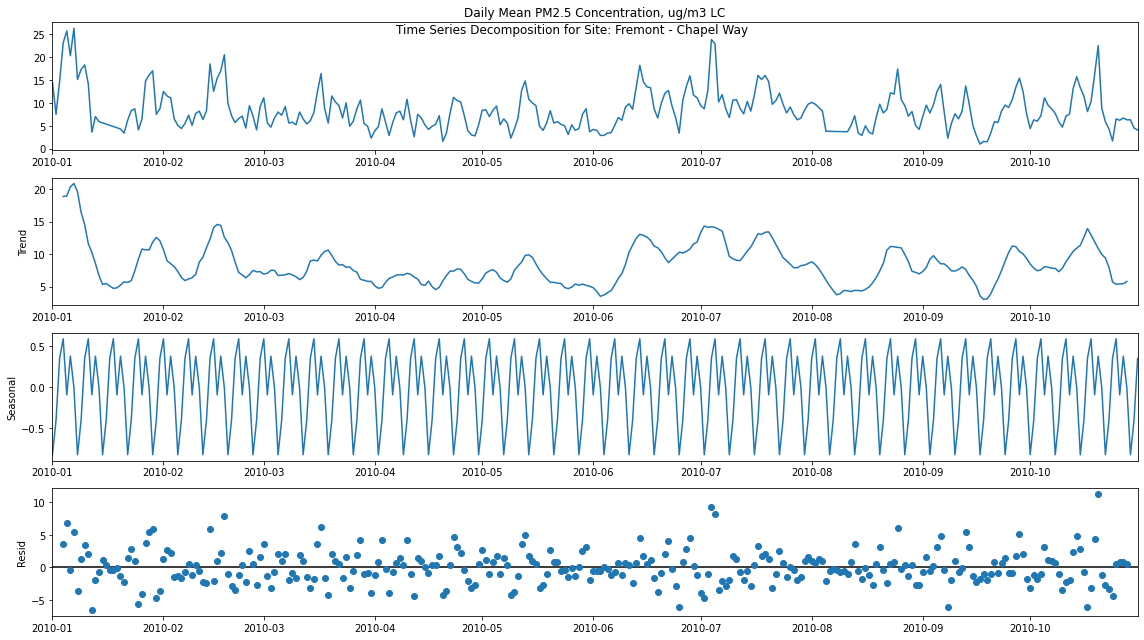

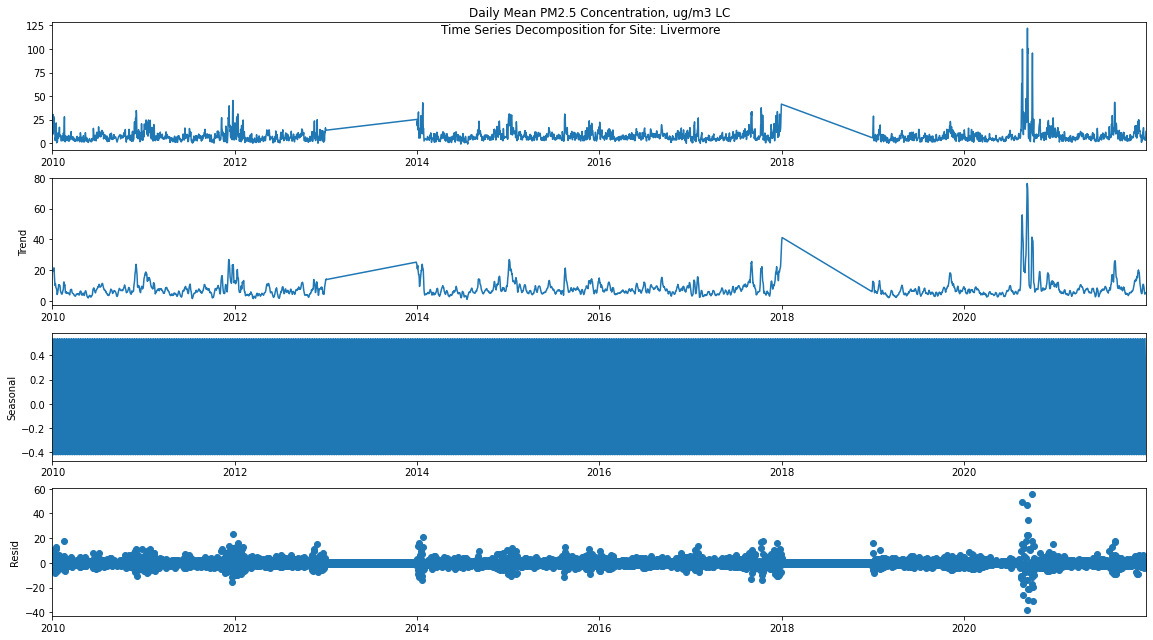

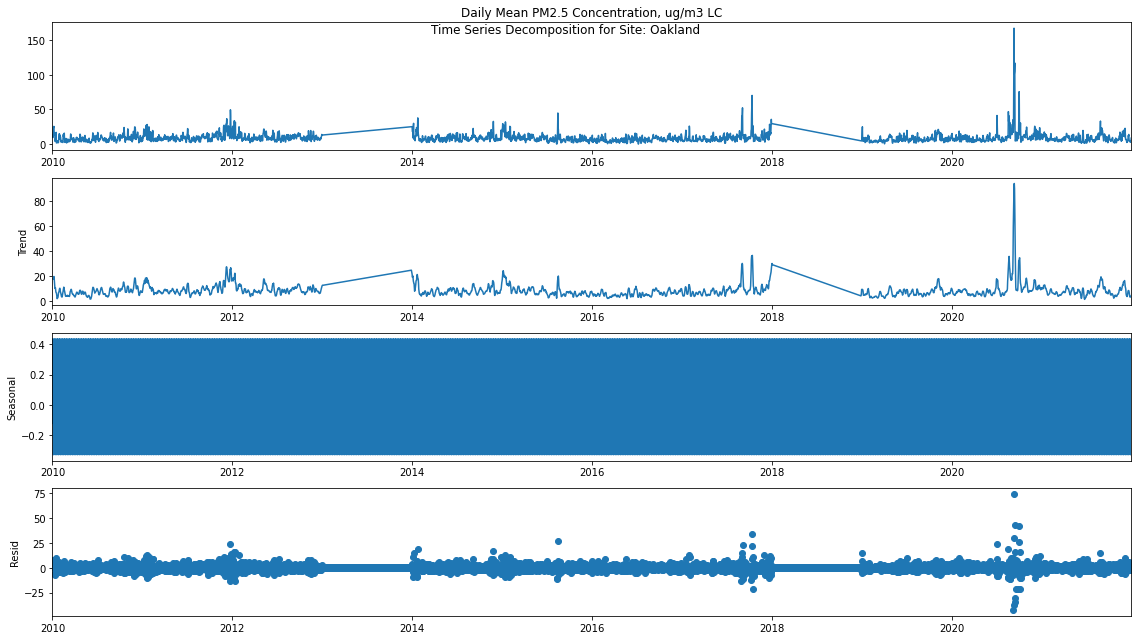

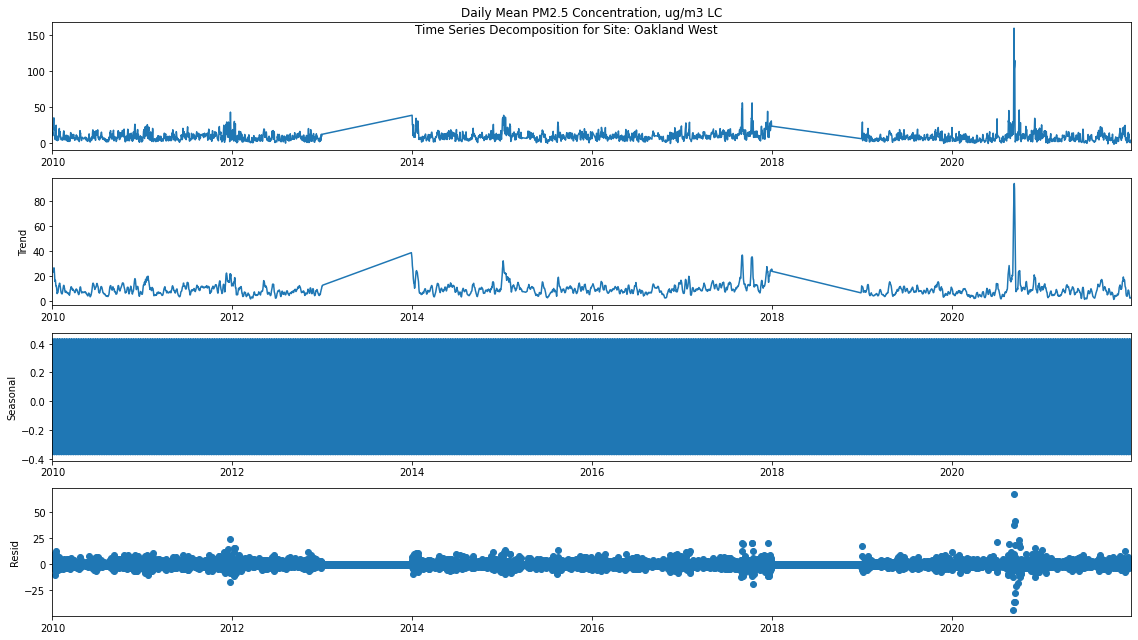

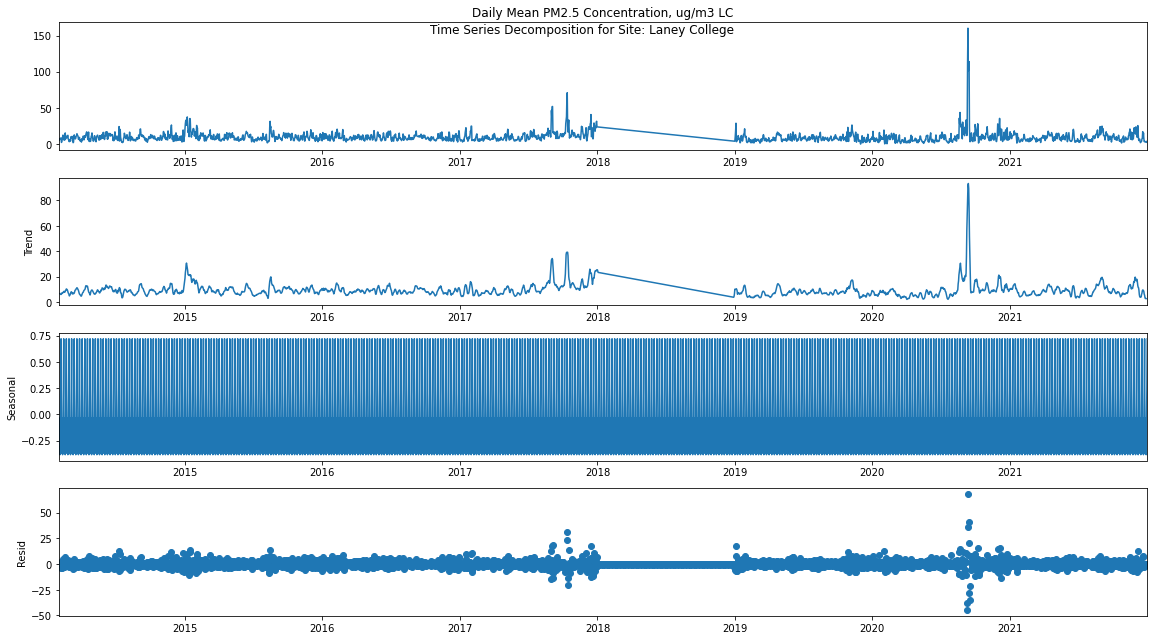

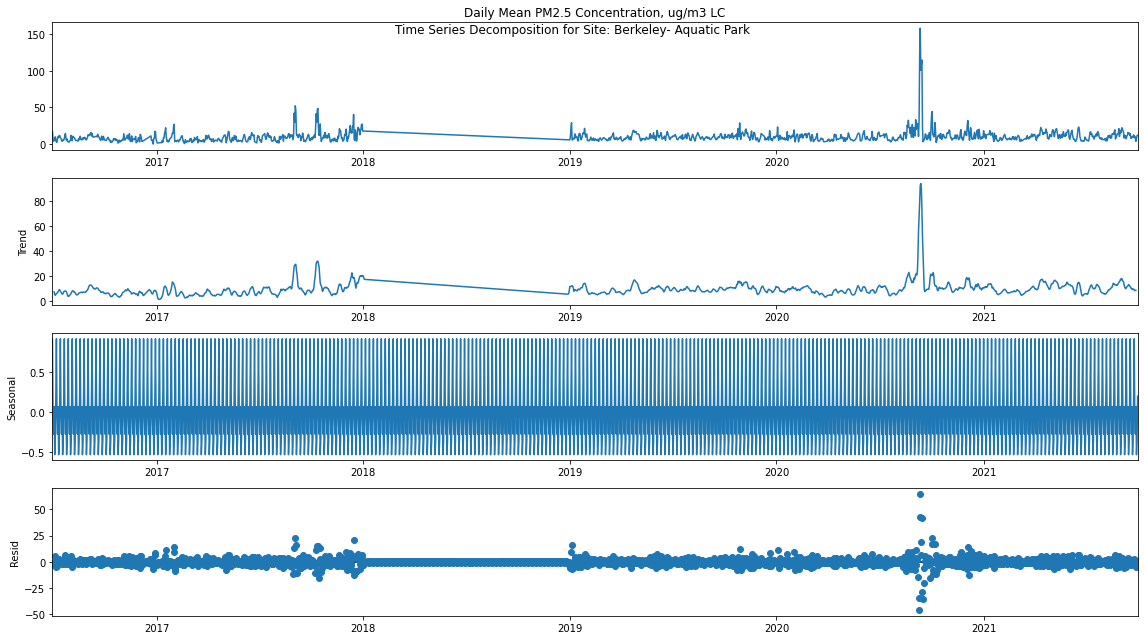

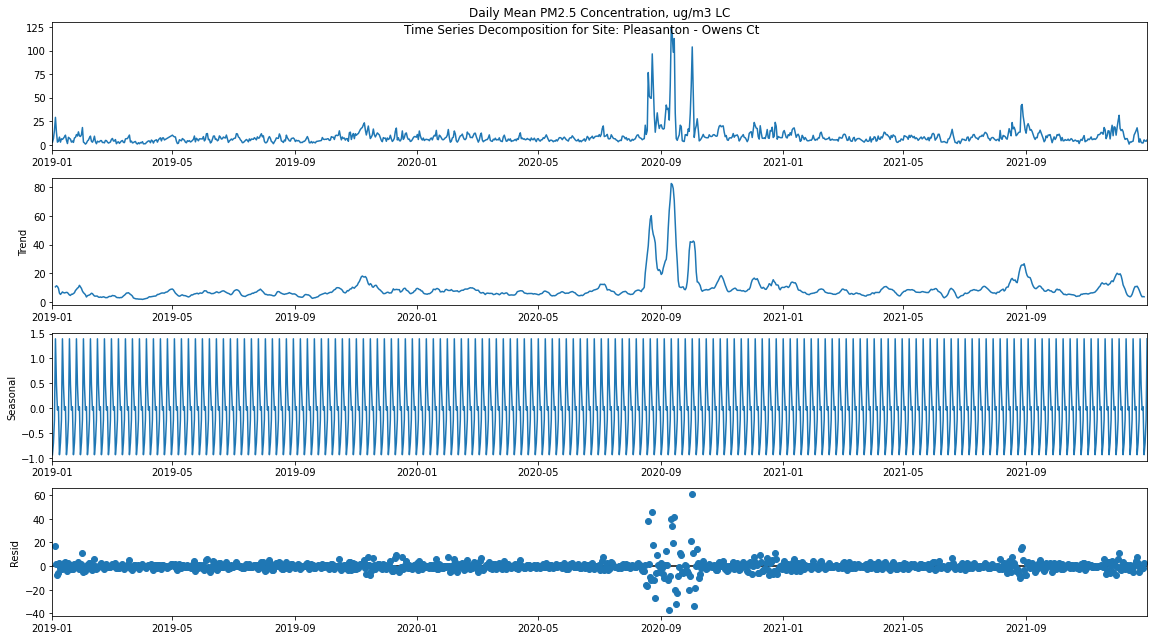

In [398]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming 'Date' column contains date values in a string format (if not, convert it to datetime)
Alameda_df_unique['Date'] = pd.to_datetime(Alameda_df_unique['Date'])

# Define a list of unique site names
site_names = Alameda_df_unique['Site Name'].unique()

# Create a directory to save plots (optional)
import os
output_dir = 'time_series_plots/Alameda'
os.makedirs(output_dir, exist_ok=True)

# Set the figure size for larger plots
#plt.figure(figsize=(30, 15))

# Iterate through each site and perform time series analysis
for site_name in site_names:
    
    # Filter data for the current site
    site_data = Alameda_df_unique[Alameda_df_unique['Site Name'] == site_name]
    
    # Check for duplicate dates
    if site_data['Date'].duplicated().any():
        print(f"Duplicate dates found for site: {site_name}. Removing duplicates.")
        site_data = site_data[~site_data['Date'].duplicated()]
    
    # Set the 'Date' column as the DataFrame index
    site_data.set_index('Date', inplace=True)
    
    # Reindex to include all dates in the desired range (e.g., daily frequency 'D') and fill missing values
    site_data = site_data.reindex(pd.date_range(start=site_data.index.min(), end=site_data.index.max(), freq='D'))
    site_data['Daily Mean PM2.5 Concentration, ug/m3 LC'] = site_data['Daily Mean PM2.5 Concentration, ug/m3 LC'].interpolate()
    
    # Decompose the time series into trend, seasonal, and residual components
    decomposition = sm.tsa.seasonal_decompose(site_data['Daily Mean PM2.5 Concentration, ug/m3 LC'], model='additive')
    
    # Plot the decomposed components
    fig = decomposition.plot()
    fig.set_size_inches((16, 9))
    fig.tight_layout()
    plt.suptitle("\n" + f'Time Series Decomposition for Site: {site_name}')
    
    # Save the plot 
    plt.savefig(os.path.join(output_dir, f'time_series_decomposition_{site_name}.png'))
    
    # Show the plot
    plt.show()


In [403]:
Alameda_df_unique["Day"] = pd.DatetimeIndex(Alameda_df_unique['Date']).day

In [407]:
Alameda_model_df = Alameda_df_unique[['Date', 'Site Name', 'Daily Mean PM2.5 Concentration, ug/m3 LC', 'SITE_LATITUDE', 'SITE_LONGITUDE', 'Year', 'Month','Day']]
Alameda_model_df

Date              Site Name  \
0     2010-01-01               Berkeley   
1     2010-01-01   Fremont - Chapel Way   
2     2010-01-01              Livermore   
3     2010-01-01                Oakland   
4     2010-01-01           Oakland West   
...          ...                    ...   
17111 2021-12-31          Laney College   
17112 2021-12-31              Livermore   
17113 2021-12-31                Oakland   
17114 2021-12-31           Oakland West   
17115 2021-12-31  Pleasanton - Owens Ct   

       Daily Mean PM2.5 Concentration, ug/m3 LC  SITE_LATITUDE  \
0                                          11.8      37.877794   
1                                          14.5      37.535833   
2                                          18.5      37.687526   
3                                          12.2      37.743065   
4                                          14.7      37.814781   
...                                         ...            ...   
17111                                       3.0      37.793624   
17112                                      12.5      37.687526   
17113                                       8.3      37.743065   
17114                                       4.7      37.814781   
17115                                       5.2      37.701222   

       SITE_LONGITUDE  Year  Month  Day  
0         -122.301290  2010      1    1  
1         -121.961823  2010      1    1  
2         -121.784217  2010      1    1  
3         -122.169935  2010      1    1  
4         -122.282347  2010      1    1  
...               ...   ...    ...  ...  
17111     -122.263376  2021     12   31  
17112     -121.784217  2021     12   31  
17113     -122.169935  2021     12   31  
17114     -122.282347  2021     12   31  
17115     -121.903019  2021     12   31  

[16387 rows x 8 columns]

In [253]:
from pathlib import Path  
filepath = Path('Alameda_df_unique.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
Alameda_df_unique.to_csv(filepath)  

In [415]:
Alameda_df_unique = pd.read_csv('Alameda_df_unique.csv')

In [416]:
wildfire_df = pd.read_csv("California wildfire data collection 2008_2019 - California wildfire data collection 2008_2019.csv")
wildfire_df

Incident Name Incident Number          County     Fire Name  Start Date  \
0           Bluff             NaN  San Bernardino           NaN   3/16/2008   
1         Colyear             NaN    Tehama-Glenn           NaN    5/6/2008   
2         Avocado             NaN    Fresno-Kings           NaN   5/20/2008   
3           Gatos             NaN    Fresno-Kings           NaN   5/22/2008   
4          Summit             NaN     Santa Clara           NaN   5/22/2008   
..            ...             ...             ...           ...         ...   
810           NaN        LFD-1582     Los Angeles  SADDLE RIDGE  10/10/2019   
811           NaN       ENF-30945       El Dorado        CAPLES  10/10/2019   
812           NaN      LAC-326166     Los Angeles          TICK  10/24/2019   
813           NaN        LFD-1583     Los Angeles         GETTY  10/28/2019   
814           NaN        LPF-2908   Santa Barbara          CAVE  11/25/2019   

     Cont. Date Origin DPA Consumed Acres Total Vegetation Type  \
0     3/20/2008        NaN                  680    Brush, Grass   
1      5/9/2008        NaN                1,331           Brush   
2     5/21/2008        NaN                1,100           Grass   
3     5/22/2008        NaN                  331           Grass   
4     6/15/2008        NaN                4,270          Timber   
..          ...        ...                  ...             ...   
810  10/26/2019      LOCAL                8,799         B, G, T   
811  10/31/2019       USFS                3,435            B, T   
812  10/31/2019      LOCAL                3,950            B, G   
813  11/14/2019      LOCAL                  745            B, G   
814  12/13/2019       USFS                3,126            B, G   

                Cause Structures Destroyed  Structures Damaged  \
0            Campfire                    0                   0   
1              Debris                    0                   0   
2       Equipment Use                    0                   0   
3       Miscellaneous                    0                   0   
4        Unidentified                   91                   2   
..                ...                  ...                 ...   
810      UNDETERMINED                   24                  91   
811   PRESCRIBED FIRE                    0                   0   
812      UNDETERMINED                   29                  46   
813  ELECTRICAL POWER                   13                  19   
814      UNDETERMINED                    0                   1   

     Fatalities Fire  Fatalities Civil  Injuries  
0                  0               0.0       NaN  
1                  0               0.0       NaN  
2                  0               0.0       NaN  
3                  0               0.0       NaN  
4                  0               0.0       NaN  
..               ...               ...       ...  
810                0               1.0       NaN  
811                0               0.0       NaN  
812                0               0.0       NaN  
813                0               0.0       NaN  
814                0               0.0       NaN  

[815 rows x 15 columns]

In [419]:
wildfire_df[wildfire_df['County'] == "Alameda"]

Incident Name Incident Number   County Fire Name Start Date Cont. Date  \
231           NaN      SCU-002461  Alameda    DIABLO  6/18/2010  6/19/2010   
698           NaN        SCU-4856  Alameda     GRANT   7/8/2018   7/9/2018   

    Origin DPA Consumed Acres Total Vegetation Type         Cause  \
231    CALFIRE                  475               G  Undetermined   
698   CAL FIRE                  480               G     FIREWORKS   

    Structures Destroyed  Structures Damaged  Fatalities Fire  \
231                    1                   0                0   
698                    1                   0                0   

     Fatalities Civil  Injuries  
231               0.0       NaN  
698               0.0       NaN

In [ ]:
#Create plot for months to see seasonality
#Check for NA, fillna with mean or 0
#Check for outliers
#Check if all rows are distinct or there are duplicates
#Look at distributions of feature values
#Count, min and max of numerical values
#time series of pm2.5
#change of pm2.5 depending of geo coordinates at the same day
#change of pm2.5 of 1 site with time

#create plots with max values
#add equation, r2 and p-value to trend for mean for every county
#make all plots scaled at the same range

#add logarifmic scale
#remove outliers, add confidence interval
#add confidence intervals, add avg for months
#timeseries

#All the redbook pdfs are there towards the bottom- under “Past wildfire activity statistics”
#Redbook 2018 - https://osfm.fire.ca.gov/media/5590/2018-strategic-fire-plan-approved-08_22_18.pdf
#Link for Calfire pdfs- https://www.fire.ca.gov/our-impact/statistics
#link pdf redbook location and time to counties
#repeat month plot to each part of Alameda
#compare 2 most polluted counties

#add time frame to the titles of mean months
#add confidence interval to the plots
#add geographical map
#add wildfires to the map
#create plots for 5 and 1 year
#add CO2 and ozon data

#create plot of average max pm2.5 values by month
#how to create time series if I don't have consistent data?
#create unique df for each county
#add html to presentation

#add a graph for the mean amount of wildfires for every month 
#and graph with average amount of acres burnt
#divide timeseries to make it without empty parts
#how to add html to presentation

